<h2>CAPP 30254: Machine Learning for Public Policy</h2>
Assignment 3: Pipeline Improvement and Empirical Comparisons<br />
Ye Ji <br />
May 3, 2017 <br />


### Goal: 
The goal is to improve the pipeline based on the feedback from previous assignments, and add a few components based on what we've covered in the past few lectures. More specifically, you need to:

### Coding Assignment:

1. Fix and improve the pipeline code you submitted for the last assignment based on the feedback from the TAs.

2. Add more classifiers to the pipeline: Logistic Regression, K-Nearest Neighbor, Decision Trees, SVM, Random Forests, Boosting, and Bagging. The code should have a parameter for running one or more of these classifiers and your analysis should run all of them.

3. Experiment with different parameters for these classifiers (different values of k for example, as well as parameters that other classifiers have). You should look at the sklearn documentation to see what parameter each classifier can take and what the default values sklearn selects.

4. Add additional evaluation metrics: accuracy, precision at different levels, recall at different levels, F1, area under curve, and precision-recall curves.

5. Once you've set up the improved pipeline, you can run the data from the last assignment and compare the performance of each classifier on each evaluation metric and other dimensions (such as training/test speed). The code should produce a comparison table.

### Report:
You should also write a short report (1-2 pages) that compares the performance of the different classifiers across all the metrics for the data set used in the last assignment. Which classifier does better on which metrics? Which one runs faster? What would be your recommendation to someone who's working on the credit model?

### For pipeline improvement, I am making two main changes based on TA feedback:
1. Create ways to fill all mising values for discrete/categorical variables.
2. Style improvement to group functions by their purpose.

### Some other pipeline improvements include:
1. A more thorough data exploration, with the addition of plotting the distributions of different variables (with and without outliers), and plotting a heatmap of correlation between variables.
2. Additional functions in pre-processing and feature generation.

In [73]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pprint

from __future__ import division
from sklearn import preprocessing, cross_validation, svm, metrics, tree, decomposition
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier 
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier, OrthogonalMatchingPursuit, RandomizedLogisticRegression
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import ParameterGrid
from sklearn.metrics import *
from sklearn.preprocessing import RobustScaler#, StandardScalar, MinMaxScaler
import random
# import pylab as pl
# from scipy import optimize
from time import time

%matplotlib inline
pp = pprint.PrettyPrinter(indent=2)

______________________________________________________________________________________________
## Pipeline 1 of 6: Read and Write Data
For this section of the pipeline, the main change I made is rewriting the read_data function so it reads several common file types instead of only csv files. Then I added a similar write_data function.

In [2]:
def read_data(filepath):
    '''
    Reads csv, dta, excel, and json file. Load it as Pandas DataFrame. 
    Return: DataFrame.
    '''
    extension = re.search('.\w+$', filepath).group()
    assert extension in ['.csv', '.dta', '.xlsx', '.xls', '.json'],\
    "this function can only read file with csv, dta, xlsx, xls, and json extensions"
    if extension == '.csv':
        df = pd.read_csv(filepath)
    elif extension == '.dta':
        df = pd.read_stata(filepath)
    elif extension == '.xlsx':
        df = pd.read_excel(filepath)
    elif extension == '.json':
        df = pd.read_json(filepath)
    return df


def write_data(df, filename):
    '''
    Write DataFrame to either csv or dta file.
    '''
    extension = re.search('.\w+$', filename).group()
    assert extension in ['.csv', '.dta', '.xlsx'], "can only write to file with csv or dta extensions."
    if extension == '.csv':
        df.to_csv(filename)
    elif extension == '.dta': # sometimes needed in program evaluation to do Stata-specific operations.
        df.to_stata(filename)

_____________________________________________________________________________________________
## Pipeline 2 of 6: Data Exploration
The major changes for Data Exploration section are:
1. Improved style with function abstraction.
2. Added function to plot the distribution of variables.
3. Added function to plot the correlation matrix heatmap of variables.

In [3]:
# Note: In the future, write function that use clustering to find outliers, and function that creates cross-tabs.
def camel_to_snake(column_name):
    """
    converts a string that is camelCase into snake_case
    Example:
        print camel_to_snake("javaLovesCamelCase")
        > java_loves_camel_case
    See Also:
        http://stackoverflow.com/questions/1175208/elegant-python-function-to-convert-camelcase-to-camel-case
    """
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', column_name)
    s1 = s1.replace(" ", "_")
    s1 = s1.replace("__", "_")
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower()


def find_missing_value(df):
    '''
    Find missing value and show it in cross-tabs.
    '''
    df_lng = pd.melt(df)
    null_variables = df_lng.value.isnull()
    print(null_variables.sum())
    print(pd.crosstab(df_lng.variable, null_variables, rownames=['variable'], colnames=['missing value']))


# Note to self: After learning about clustering, complete the find_outlier function and integrate into explore_data.
def find_outlier(column):
    '''
    Find outliers by looking at distribution of values.
    '''
    pass

    
def plot_dist(df, colormap=sns.set_palette("PuBuGn_d"), outlier=True):
    '''
    Plot the distribution of each column with and without outliers.
    
    Input:
        df: DataFrame
        colormap: seaborn colormap
    '''
    COL_NUM = len(df.columns)
    fig = plt.figure(figsize=(12, 20))
    
    if outlier:
        for i in range(1, COL_NUM): # Note to self: range starts at 1 to skip person_id.
            plt.subplot(COL_NUM, 1, i)
            df[df.columns[i]].plot.box(subplots=True, vert=False, figsize=(12,1), widths=.75, fontsize=14, colormap=colormap)
        plt.suptitle("Original distribution with outliers", fontsize=30, y=0.94)
        plt.show()
    else:
        fig = plt.figure(figsize=(12, 20))
        for i in range(1,COL_NUM):
            plt.subplot(COL_NUM, 1, i)
            df[df.columns[i]].plot.box(subplots=True, vert=False, figsize=(12,1), widths=.75, fontsize=14, showfliers=False, colormap=colormap)
        plt.suptitle("Distribution without outliers", fontsize=30, y=0.94)
        plt.show()
        

# Note: In future, change the plot to show numbers on the grid.
def plot_corr(df):
    '''
    Plots a correlation heatmap for each pair of columns in the dataframe.
    
    Input:
        df: pandas DataFrame
    '''
    corr = df.corr()
    sns.heatmap(corr, 
                xticklabels=corr.columns.values,
                yticklabels=corr.columns.values,
                square=True)


def explore_data(df):
    '''
    General explore data function that snake case column names, find missing values, and plot correlations,
    by combining the functions above.
    
    Input:
        filepath: (str) Raw data file path
        df: DataFrame
    
    Return: None
    '''
    df.columns = [camel_to_snake(col) for col in df.columns]
    print()
    find_missing_value(df)
    print()
    plot_corr(df)
    print()
    plot_dist(df, outlier=True)
    plot_dist(df, outlier=False)

### Testing explore_data function:


33655
missing value                                 False  True 
variable                                                  
age                                          150000      0
debt_ratio                                   150000      0
monthly_income                               120269  29731
number_of_dependents                         146076   3924
number_of_open_credit_lines_and_loans        150000      0
number_of_time30-59_days_past_due_not_worse  150000      0
number_of_time60-89_days_past_due_not_worse  150000      0
number_of_times90_days_late                  150000      0
number_real_estate_loans_or_lines            150000      0
person_id                                    150000      0
revolving_utilization_of_unsecured_lines     150000      0
serious_dlqin2yrs                            150000      0
zipcode                                      150000      0




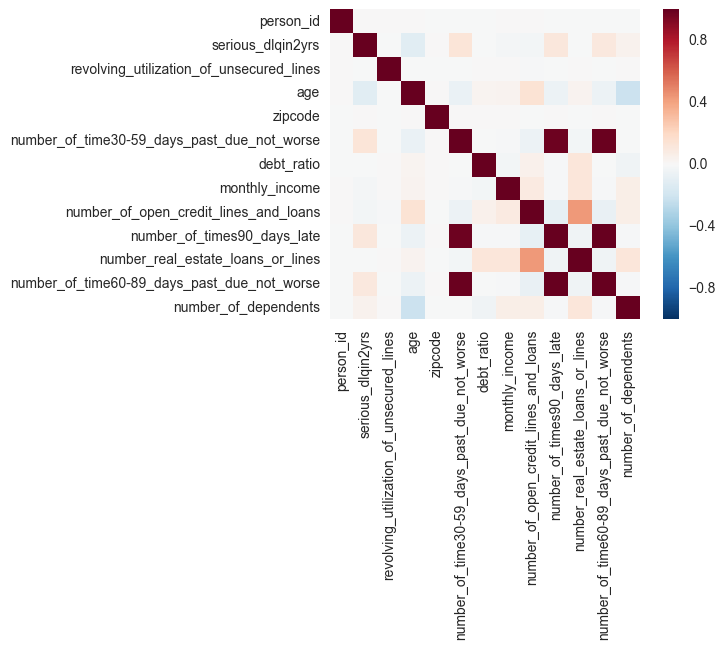

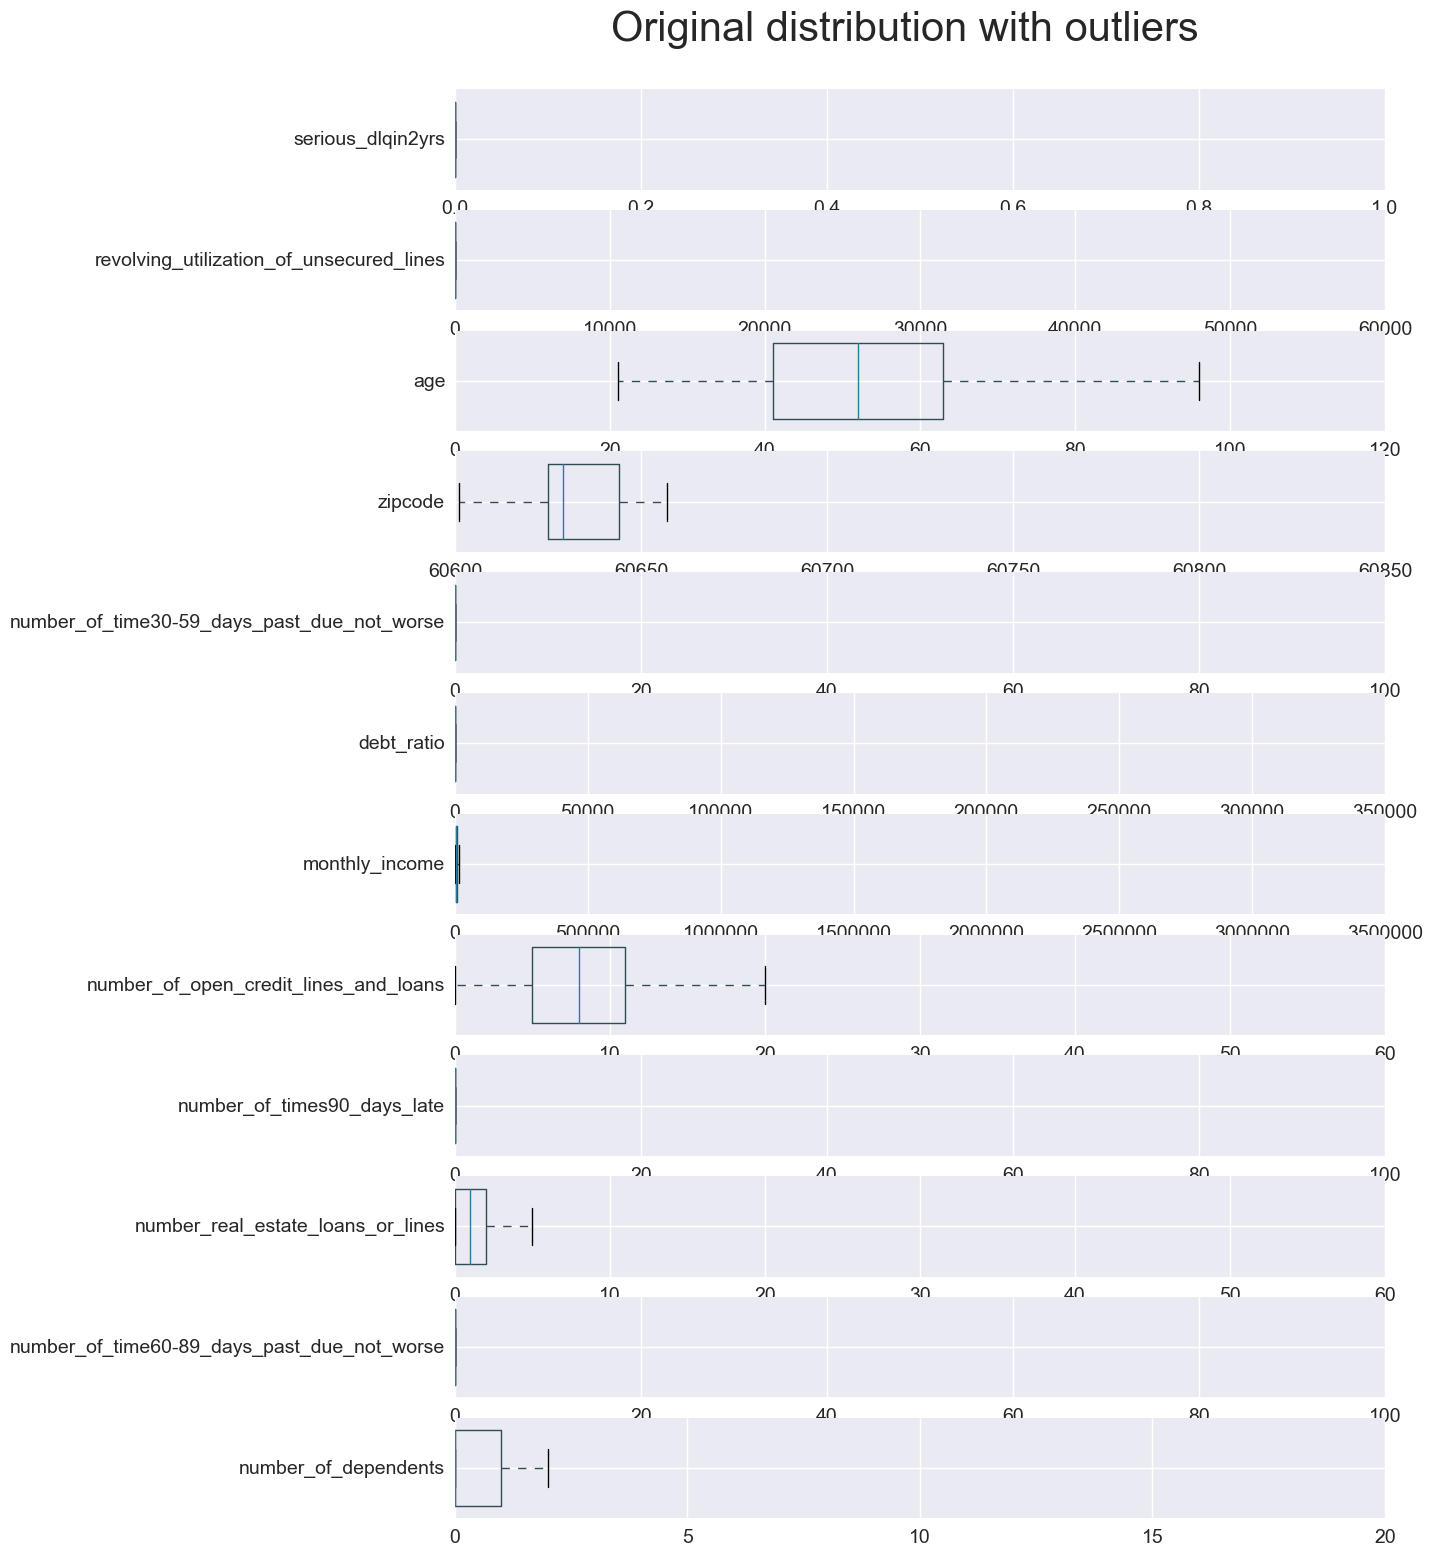

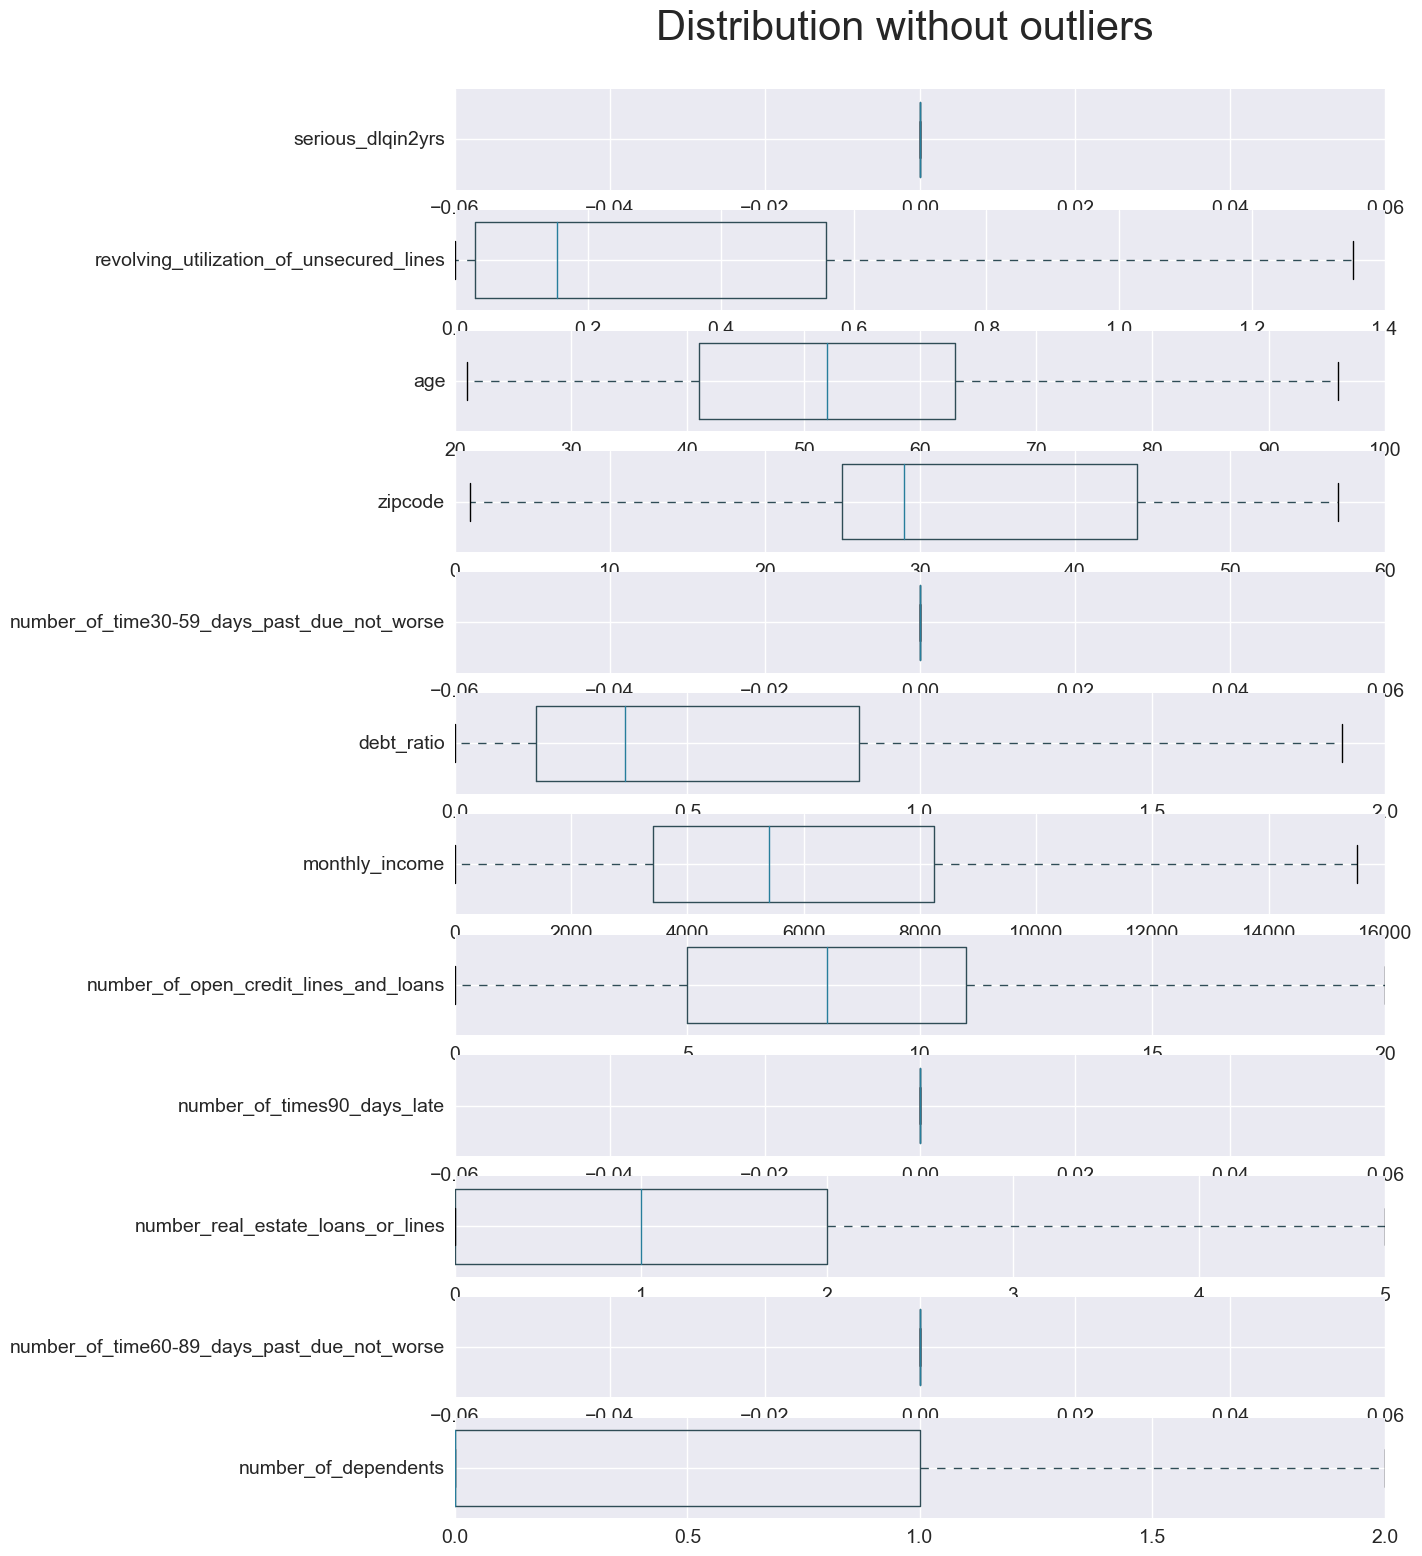

In [4]:
df = read_data('/Users/apple/GitHub/machine_learning_works/hw2/credit-data.csv')
explore_data(df)

_____________________________________________________________________________________________
## Pipeline 3 of 6: Pre-process Data
The major changes of Data Pre-processing are:
1. Improved fill missing value function. It can now take a parameter to fill missing value by any new value (mean, mode, median, or just any about anything). This change is made in response of TA feedback from the last assignment that I should write a more generic fill missing value function to take missing values in discrete and categorical variables into consideration.

In [5]:
def fill_missing(col, new_value=None):
    '''
    Check and fill missing values in a pd.Series instance.
    
    Input:
        col: DataFrame Series
        new_value: value to fill the missing value. For discrete and categorical variables, it could be col.mode(), 
                   col.median(), zero, or any specified values.
    
    Return: None
    '''
    assert col.hasnans, "This column has no missing value."
    col.fillna(new_value, inplace=True)
    return

def preprocess_data(missing_val_col, new_value=None):
    '''
    Function that groups other pre-process functions.
    For now it only consists of filling missing values.
    
    Input:
        df: DataFrame
        missing_val_col: (list) of missing value columns
        new_value: value to fill the missing value. For discrete and categorical variables, it could be col.mode(), 
                   col.median(), zero, or any specified values.
    
    Return: None
    '''
    fill_missing(missing_val_col, new_value)


### Testing preprocess_data:
1. Fill the missing values in monthly_income with median. Median income is better guess than mean income because income is often left-skewed, the median is therefore less sensitive to outliers than the mean.
2. Fill number of dependents with zero, assuming people who does not fill out their number of dependents simply does not have one.

In [6]:
preprocess_data(df.monthly_income, df.monthly_income.mean())

In [7]:
preprocess_data(df.number_of_dependents, 0)

### The print statement below checks to see all the missing values has been filled.

In [8]:
print('      Is there missing value for monthly income column? ', df.monthly_income.hasnans)
print('Is there missing value for number of dependents column? ', df.number_of_dependents.hasnans)

      Is there missing value for monthly income column?  False
Is there missing value for number of dependents column?  False


_____________________________________________________________________________________________
## ## Pipeline 4 of 6: Generate Features/Predictors
There is no major change made to this section. I added some functions to create dummy variables for my program evaluation work.

In [9]:
def discretize_continuous_var(col_name, bins, group_names):
    '''
    Discretize continuous variables.
    
    Input:
        col_name: DataFrame column name for the continuous variable.
        bins: (int) number of bins
        group_names: (list) of string of the discretize names.
    
    Return: None
    '''
    new_var_name = col_name + '_group'
    df[new_var_name] = pd.cut(df[col_name], bins, labels=group_names)

    
def create_binary_from_cat(df, col):
    '''
    Create binary dummy variables from categorical variables.
    
    Input:
        df: DataFrame
        col: (str) a column in df.
    
    Return: None
    '''
    return pd.get_dummies(col)



def create_binary_from_continuous(df, col, threshold, new_col_name):
    '''
    Create binary dummy variables from continuous variables using given threshold.
    
    Input:
        df: DataFrame
        col: (str) column whose value are used to compared to the threshold.
        threshold: (float) lower bound threshold for the binary dummy.
        new_col_name: (str) column name for the created dummy variable.
    
    Return: None
    '''
    df[new_col_name] = df[col] >= threshold
    df[new_col_name] = df[new_col_name].astype(int)

    
def create_interaction_dummy(df, col1, col2, new_col_name):
    '''
    Create interaction dummies between two columns
    
    Input:
        df: DataFrame
        col1: (str) first column to multiply.
        col2: (str) second column to multiply.
        new_col_name: (str) column name for the created dummy variable.
    
    Return: None
    '''
    df[new_col_name] = df[col1] * df[col2]

def select_feature(X, y):
    '''
    Select feature based on ExtraTreeClassifier.
    
    Input:
        X_train: DataFrame
        y_train: DataFrame
    
    Return:
        feature: (list) of features/colummns
    '''
    # from sklearn import metrics
    # from sklearn.ensemble import ExtraTreesClassifier
    
#     print(model.feature_importances_)
#     print("Top Five features:",'\n', X_train[indices[:5]].columns.values)
    
    forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)
    forest.fit(X, y)
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    print("Feature ranking:")

    for f in range(X.shape[1]):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices],
           color="0.8", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), indices)
    plt.xlim([-1, X.shape[1]])
    plt.show()
    
    feature = X[indices].columns.values
    return list(feature)

### Train-test split

In [11]:
X = df.drop(['serious_dlqin2yrs','person_id'], axis=1)
y = df['serious_dlqin2yrs']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

### Scaling
For this data set, it make sense to use robust scaling for many of the variables as they have many outliers.

In [12]:
scaler = RobustScaler()
X_train['monthly_income_scaled'] = scaler.fit_transform(X_train['monthly_income'].values.reshape(-1,1))
X_test['monthly_income_scaled'] = scaler.transform(X_test['monthly_income'].values.reshape(-1,1))
X_train['debt_ratio_scaled'] = scaler.fit_transform(X_train['debt_ratio'].values.reshape(-1,1))
X_test['debt_ratio_scaled'] = scaler.transform(X_test['debt_ratio'].values.reshape(-1,1))

/Users/apple/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/apple/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/apple/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

Feature ranking:
1. feature 0 (0.115832)
2. feature 1 (0.097116)
3. feature 4 (0.096344)
4. feature 12 (0.095947)
5. feature 7 (0.093821)
6. feature 11 (0.081945)
7. feature 5 (0.081805)
8. feature 6 (0.080717)
9. feature 3 (0.066352)
10. feature 2 (0.060784)
11. feature 9 (0.055311)
12. feature 10 (0.037256)
13. feature 8 (0.036767)


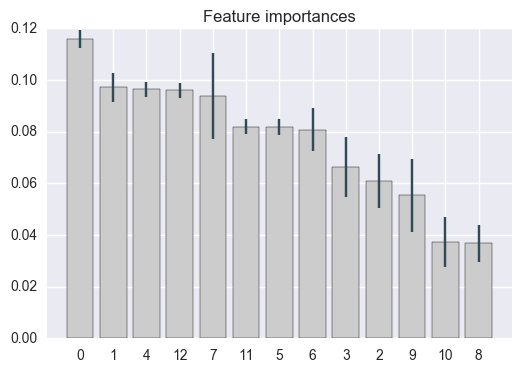

In [15]:
all_features = select_feature(X_train, y_train)

### Feature Selection
In the feature importance chart, from left to right, there are drop in relative importance between the 1st and 2nd features, the 5th and the 6th features, the 8th and the 9th features, and the 11th and the 12th features. For taking the advantage of machine learning over human's in understanding high dimensionality, we should choose more than 3 features as training features. For the KNN and SVM(linear) classifiers required by this assignment, we should ignore the unscaled debt ratio and monthly income features. For consideration in feature efficiency, we  will select the features before the 8th and 9th cutoff, minus the unscaled debt ratio and monthly income features. As a result, the selected features are:

In [18]:
features = all_features[0:2] + all_features[3:6] + all_features[7:8]
features

['revolving_utilization_of_unsecured_lines',
 'age',
 'debt_ratio_scaled',
 'number_of_times90_days_late',
 'monthly_income_scaled',
 'number_of_open_credit_lines_and_loans']

## Pipeline 5 of 6: Build Classifier
Add more classifiers to the pipeline, including Logistic Regression, K-Nearest Neighbor, Decision Trees, SVM, Random Forests, Boosting, and Bagging. (The code should have a parameter for running one or more of these classifiers and your analysis should run all of them)

In [19]:
# Code below adapted from https://github.com/rayidghani/magicloops

In [20]:
NOTEBOOK = 1

RF


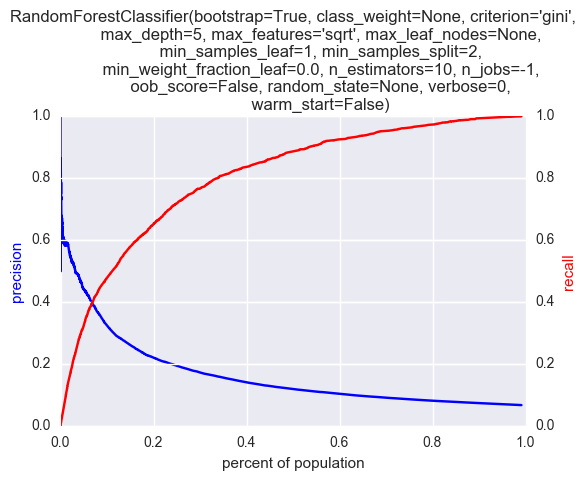

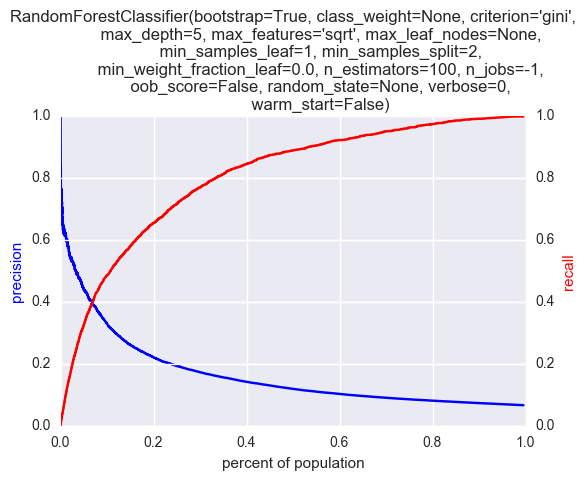

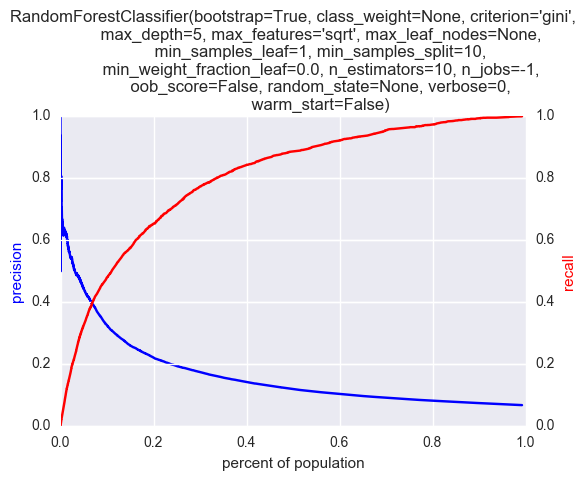

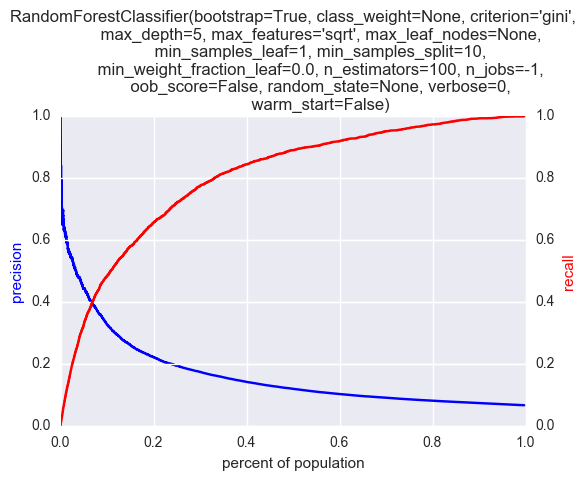

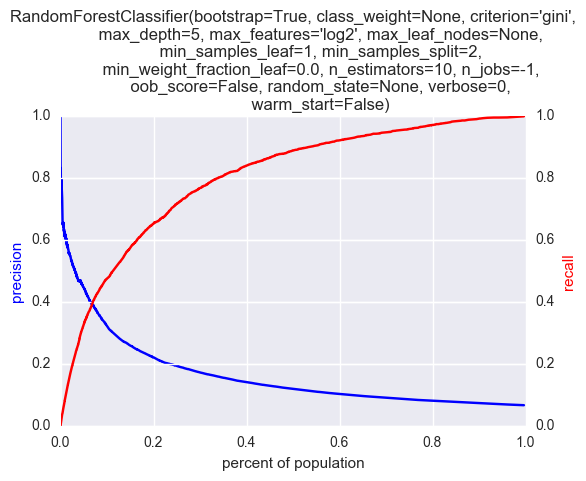

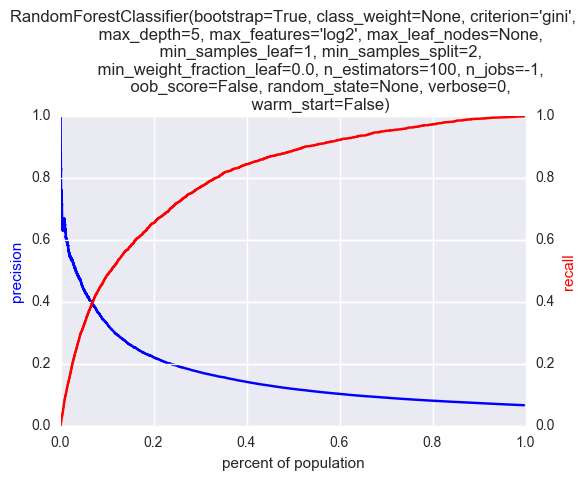

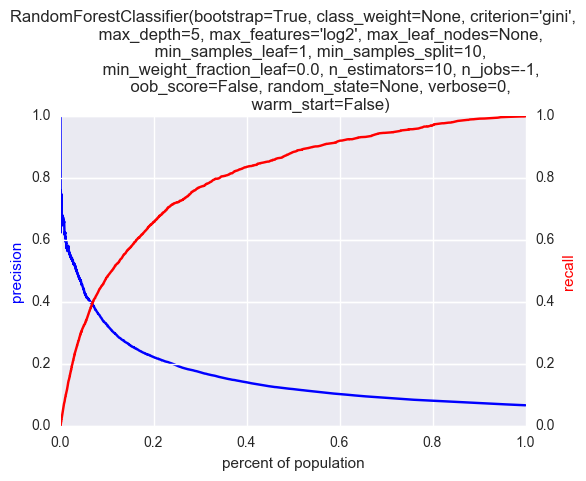

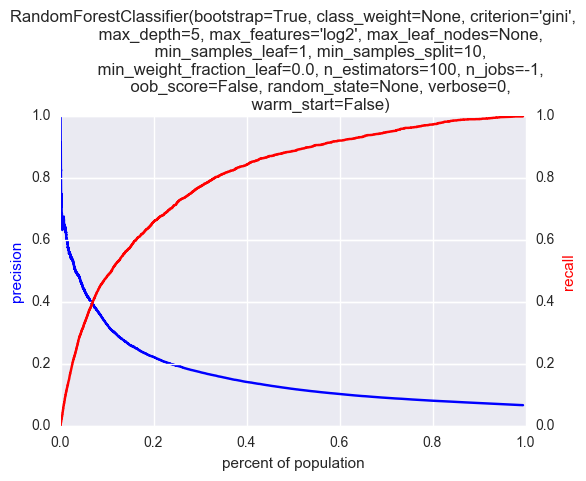

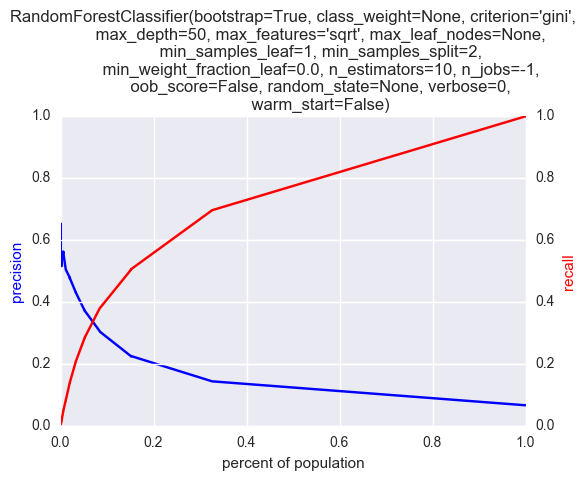

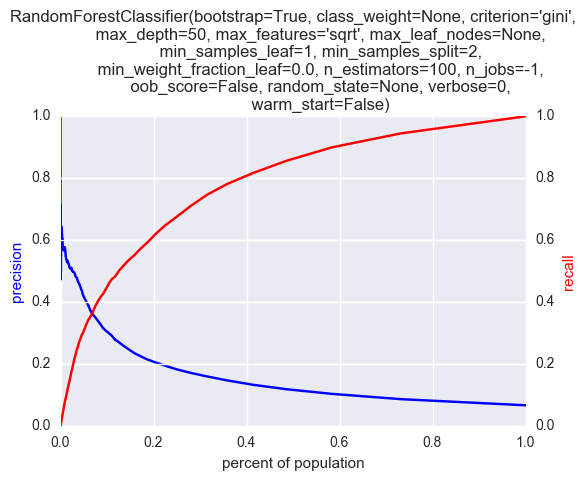

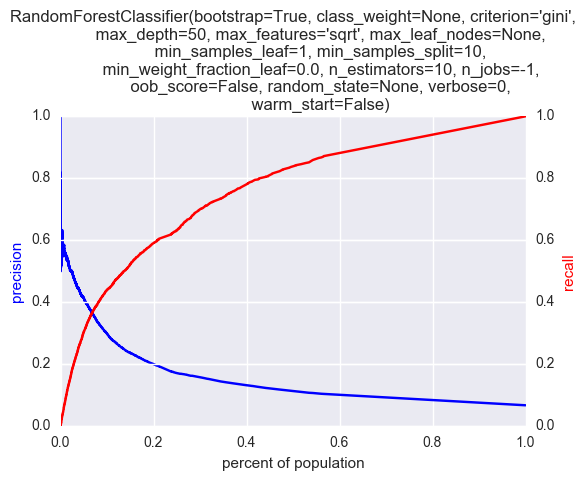

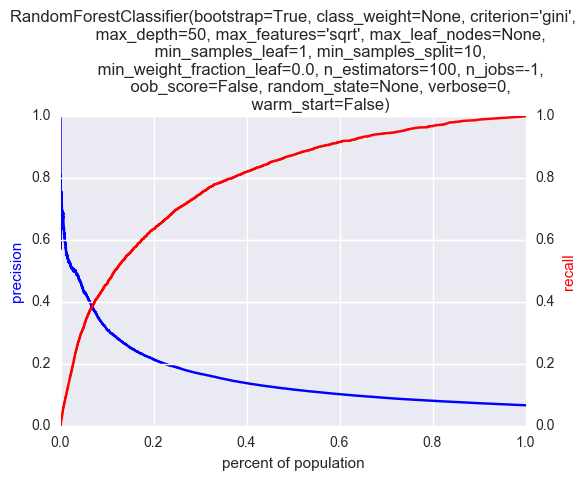

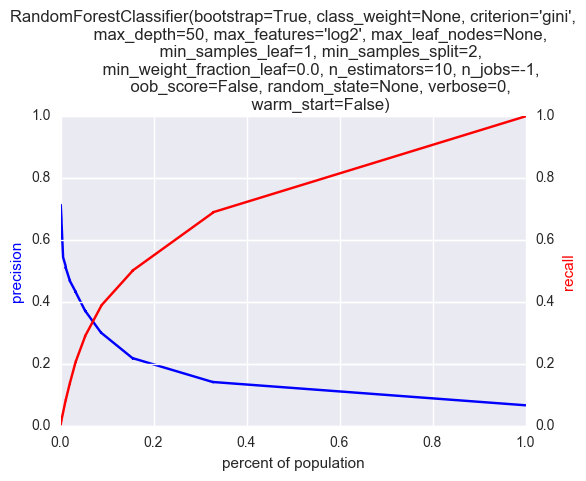

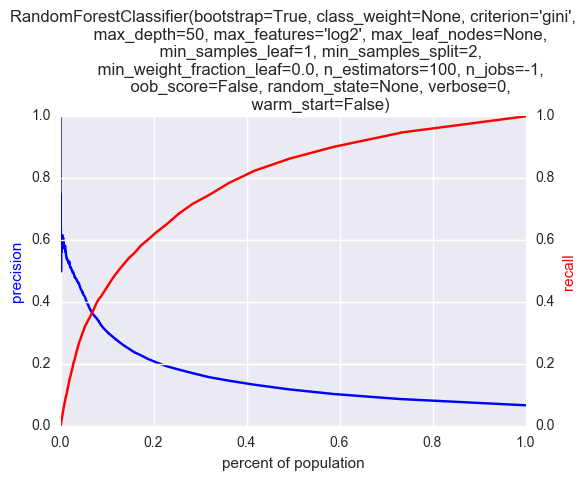

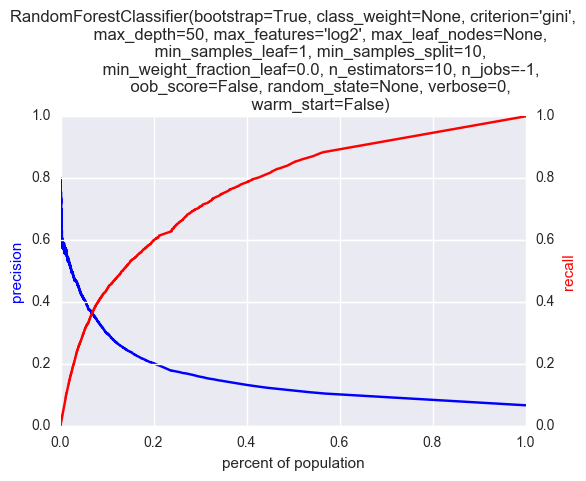

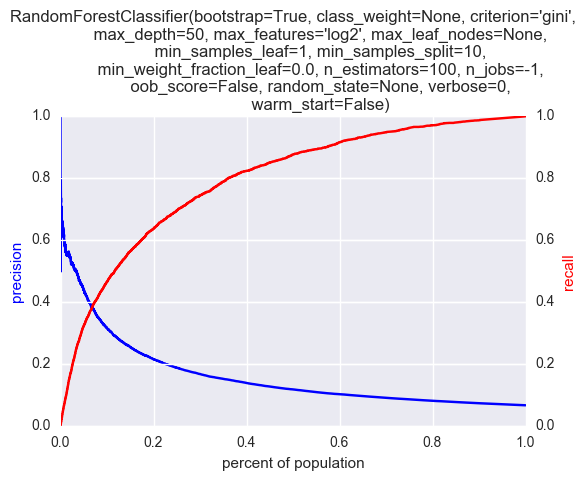

DT


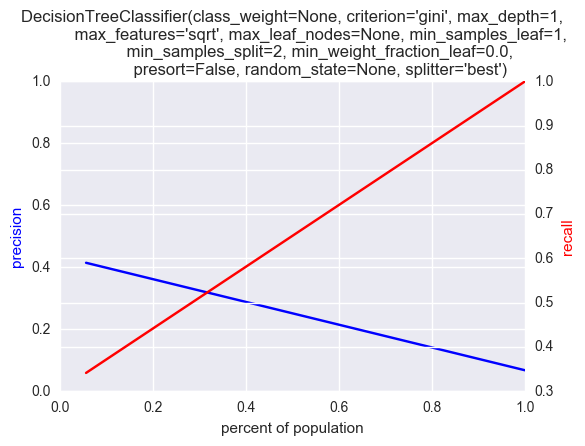

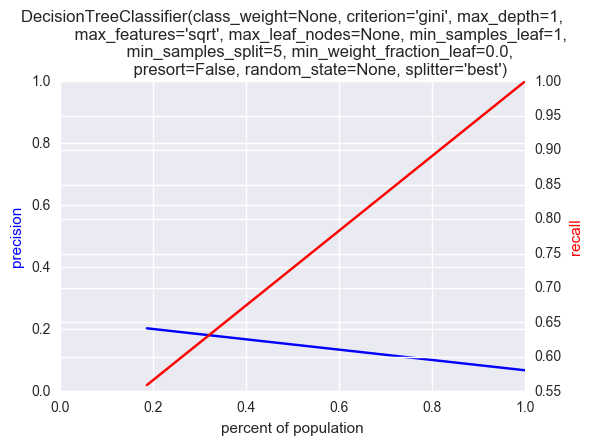

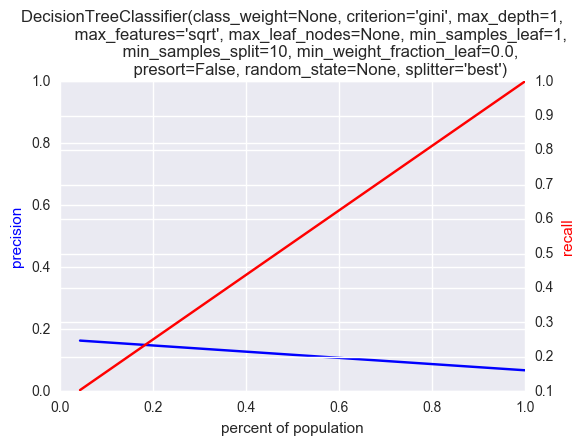

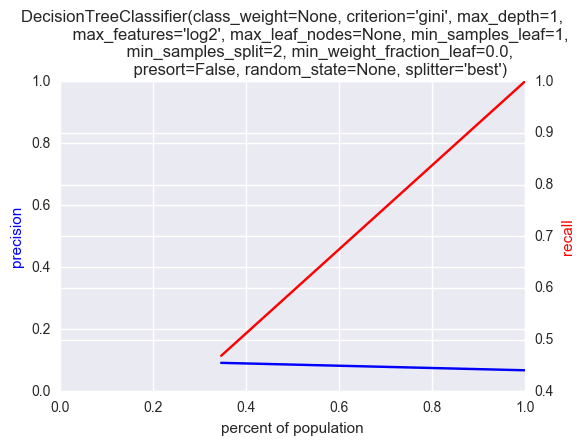

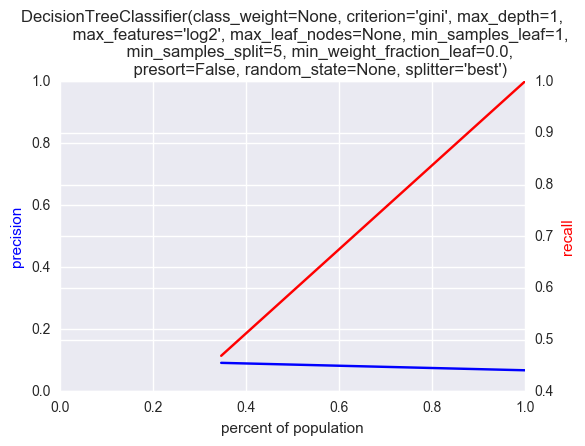

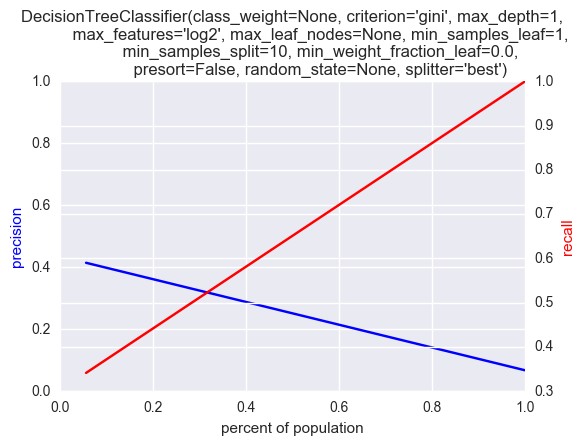

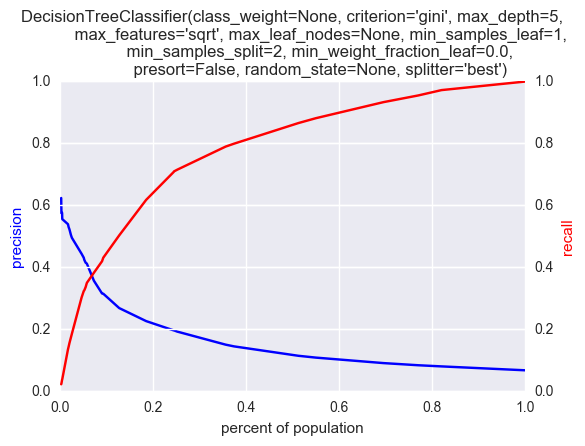

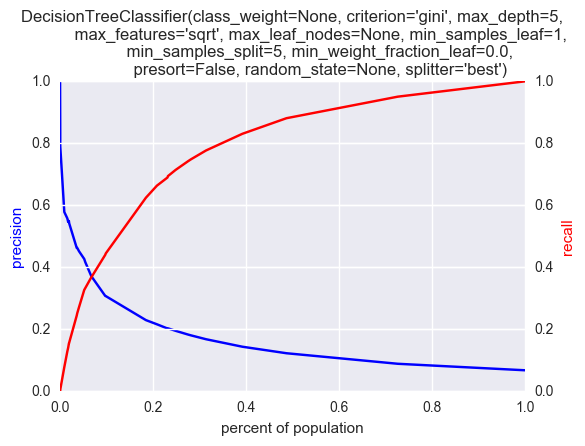

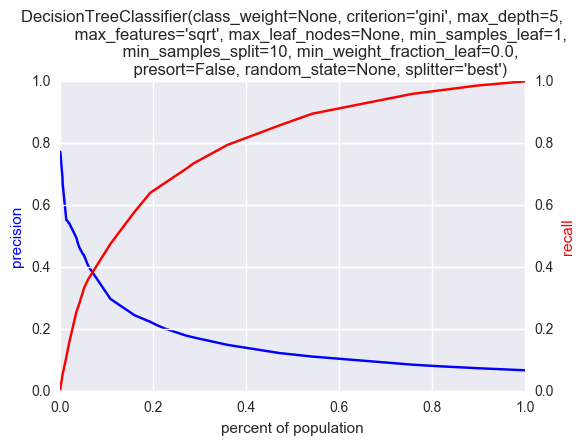

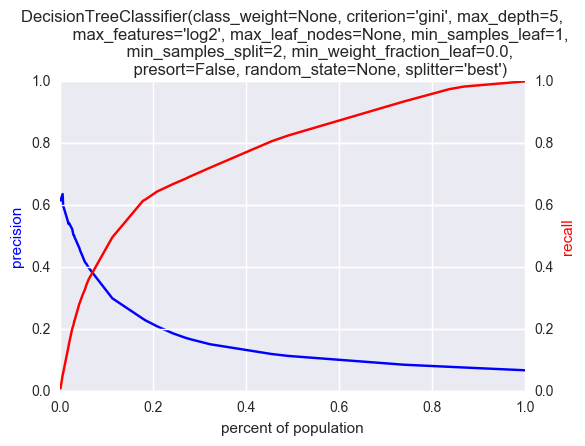

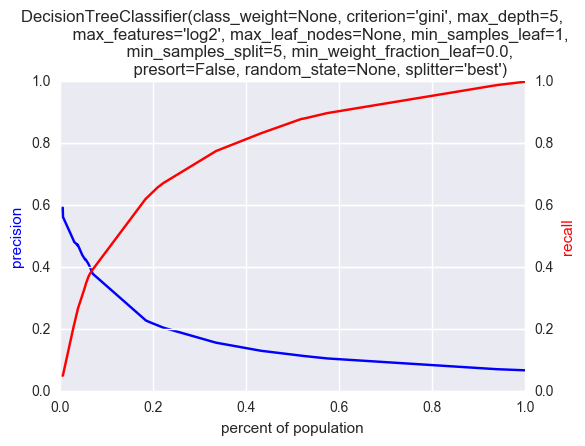

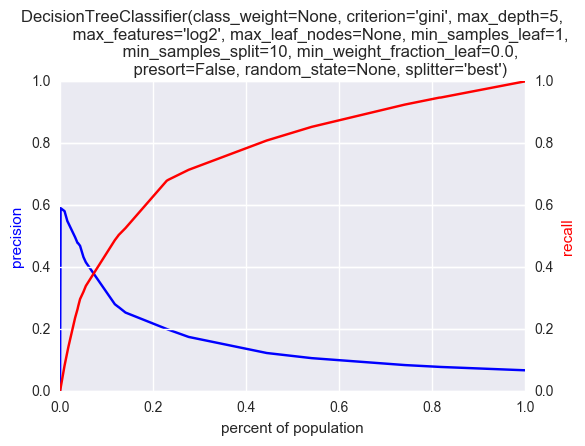

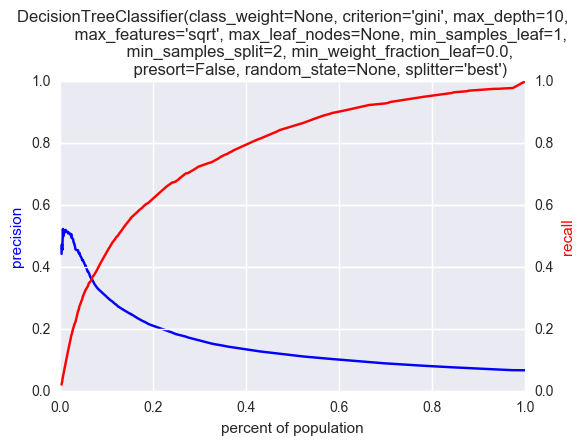

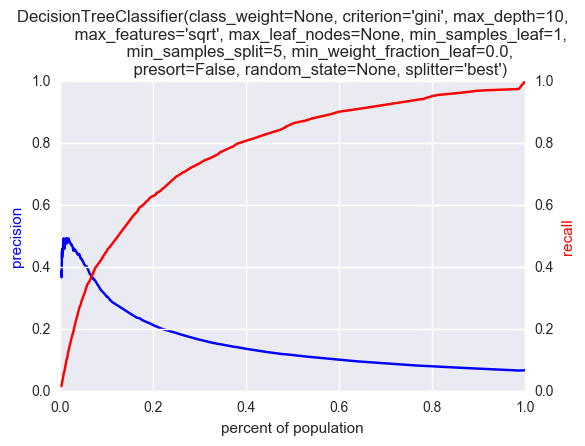

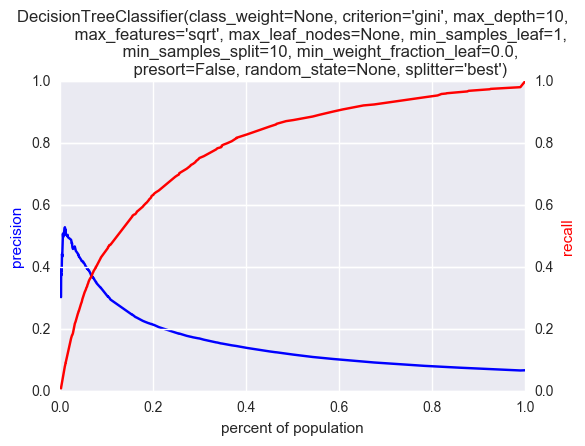

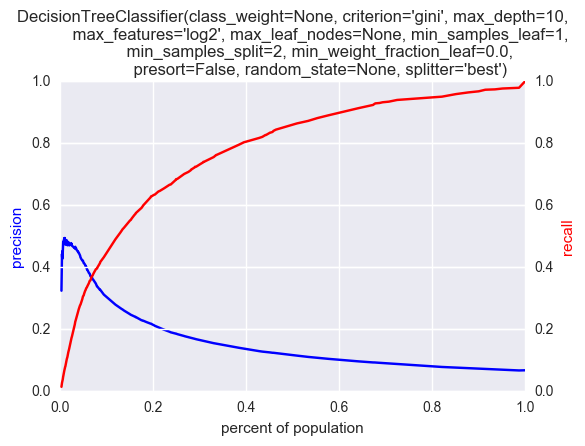

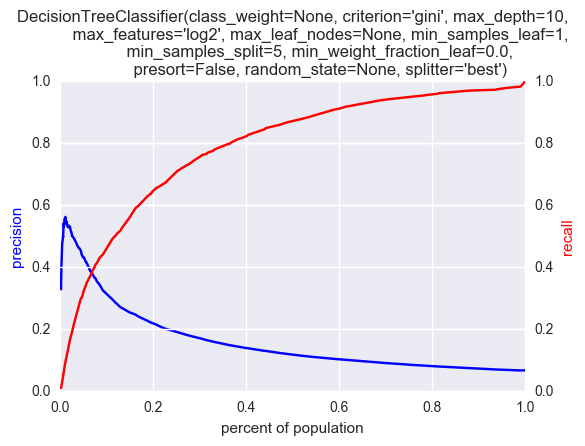

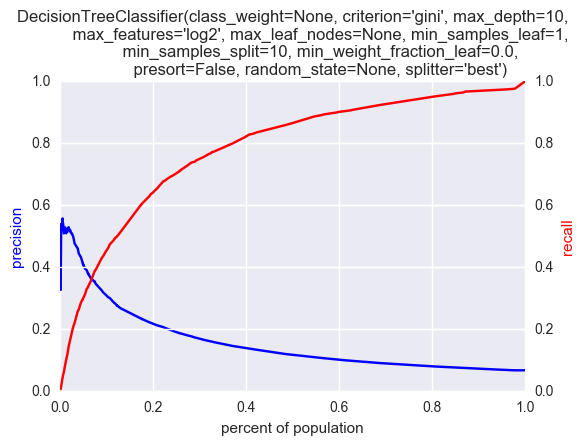

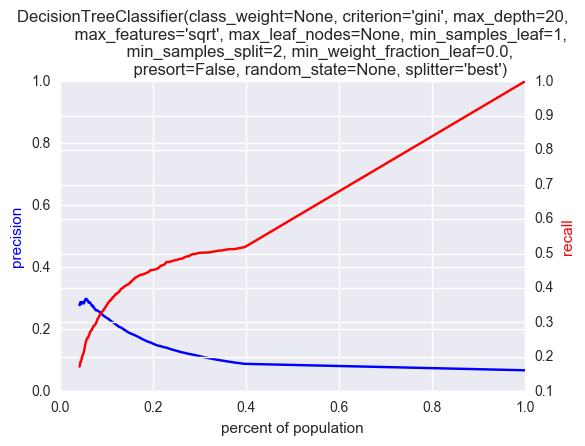

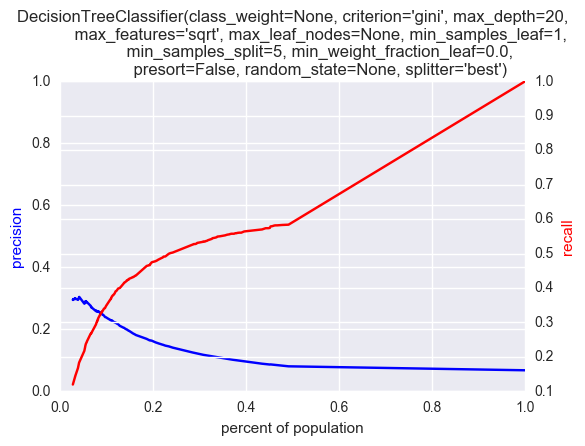

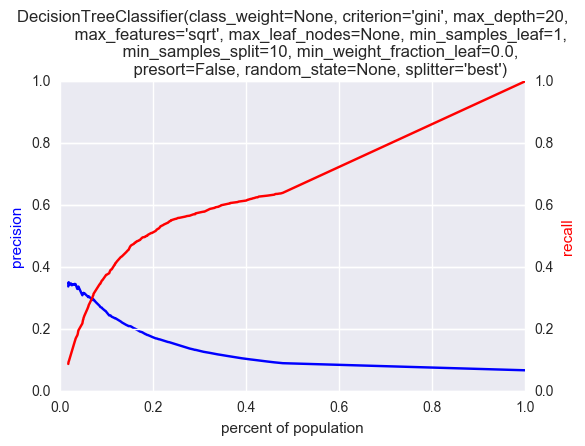

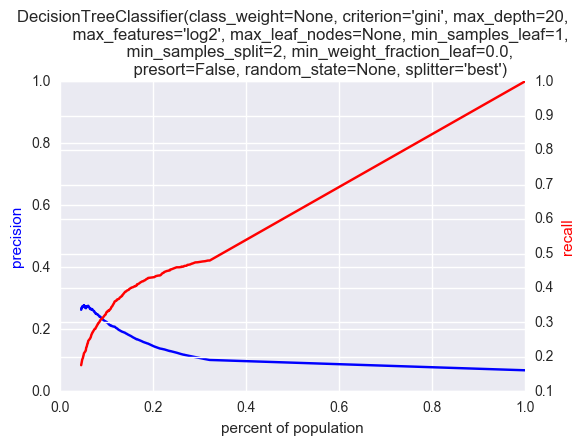

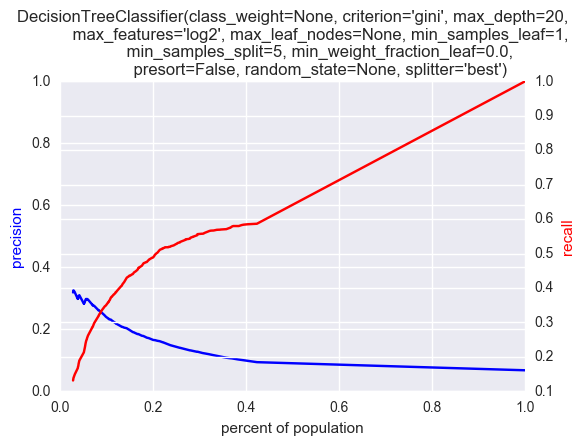

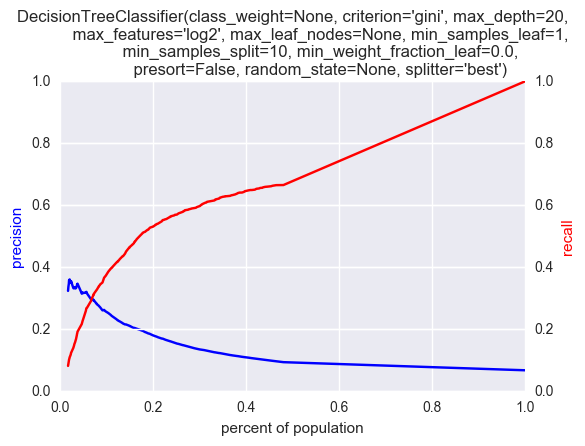

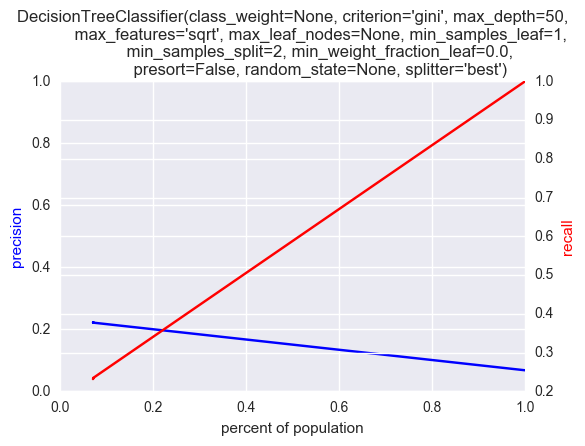

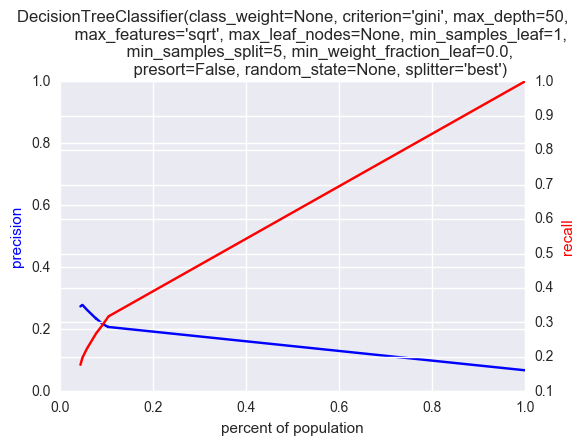

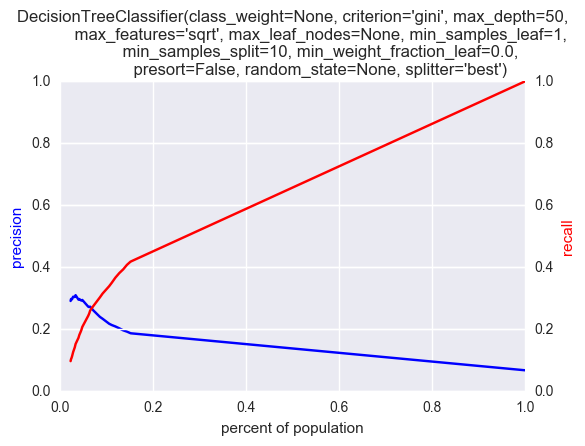

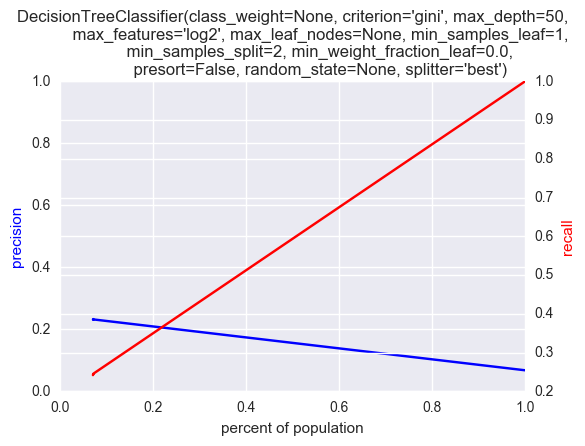

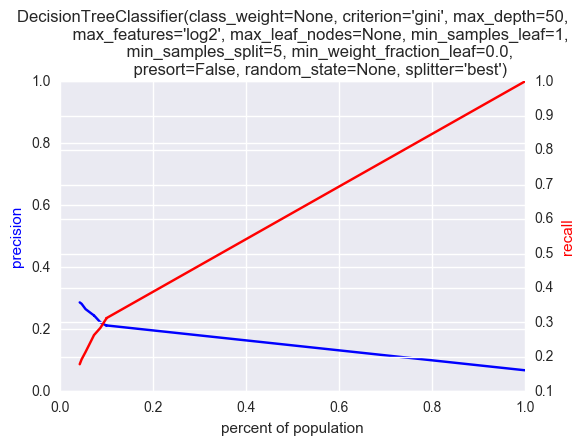

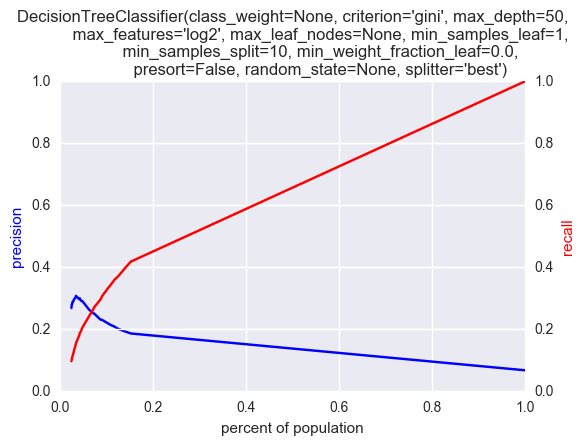

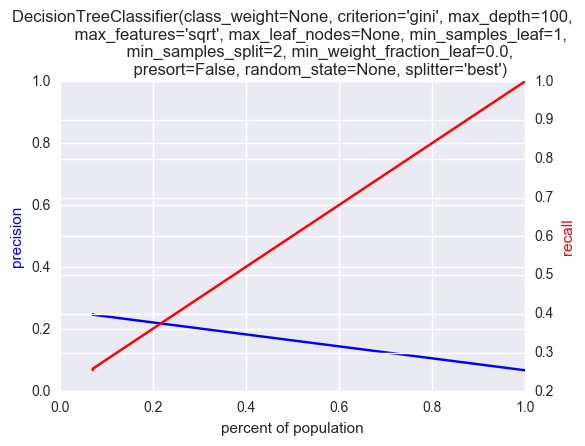

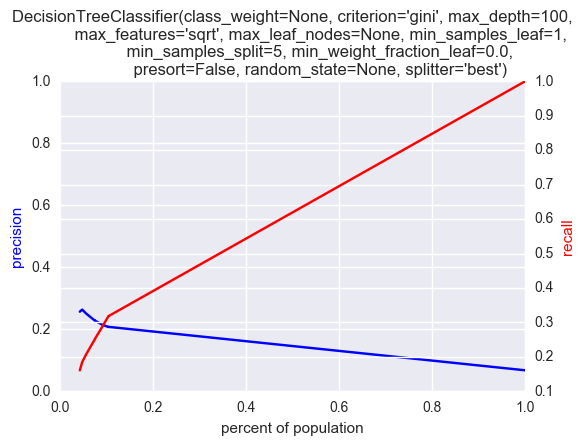

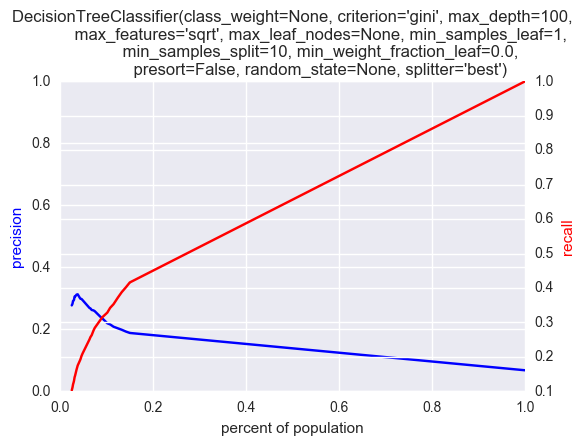

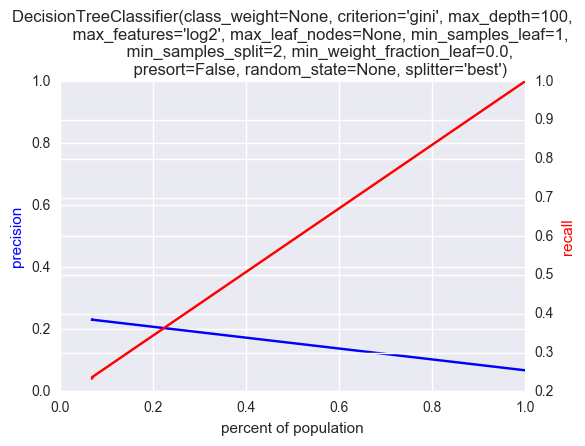

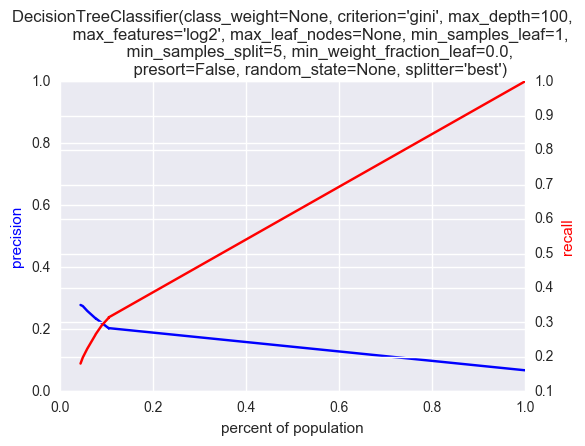

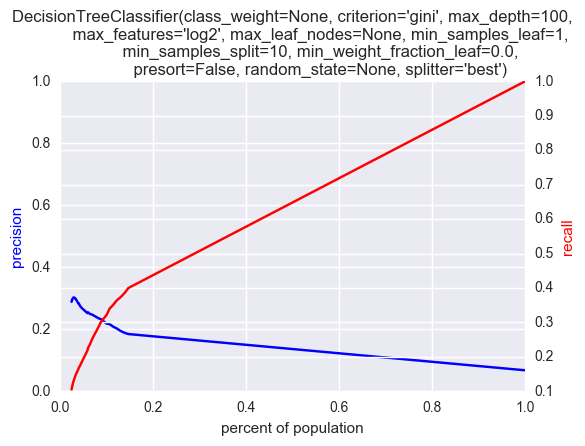

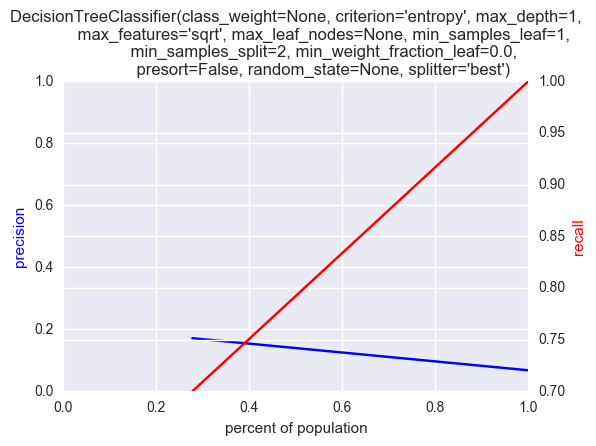

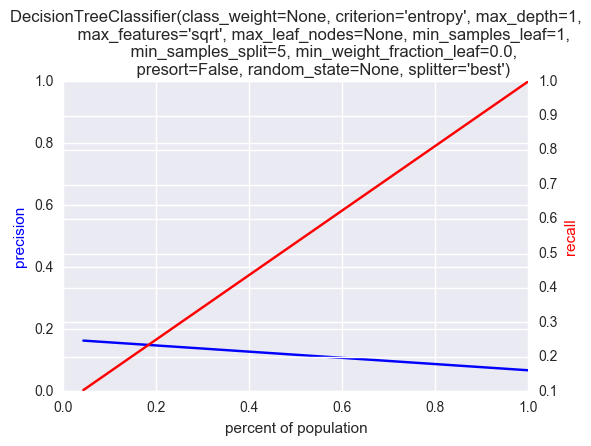

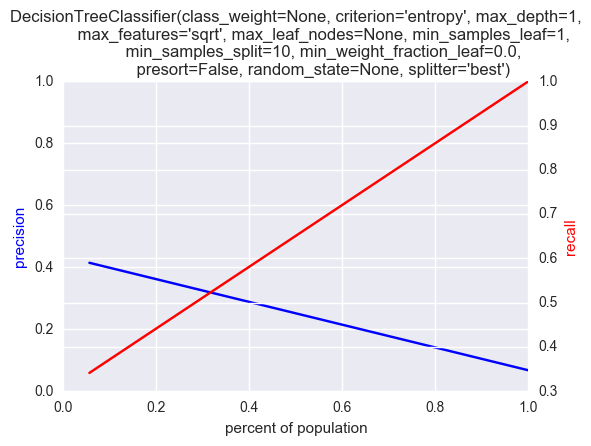

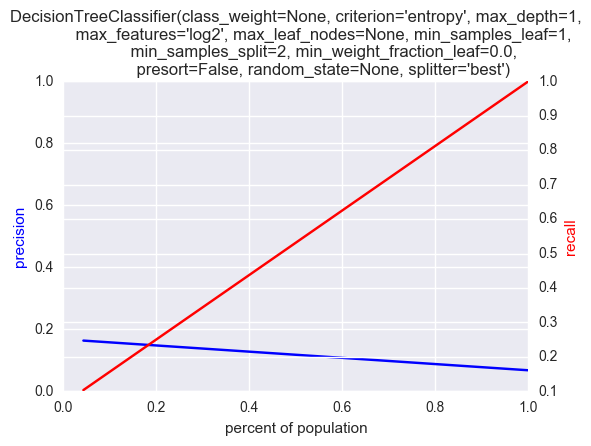

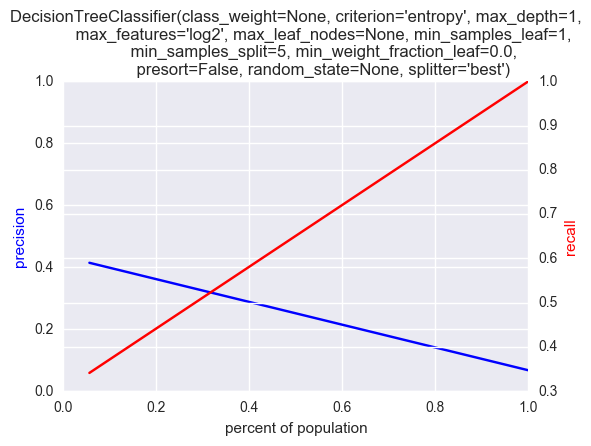

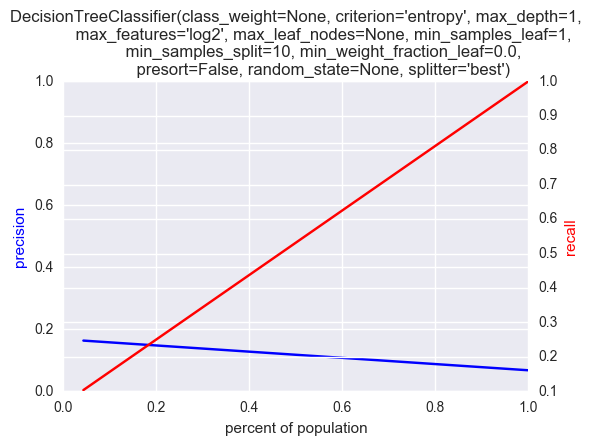

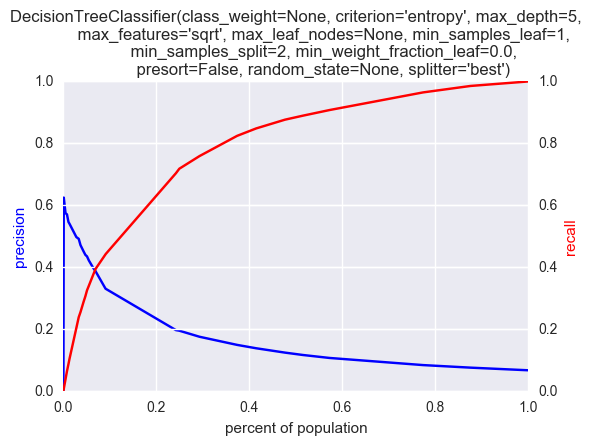

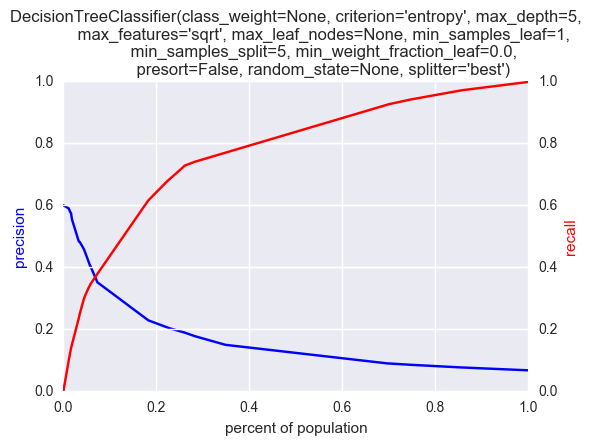

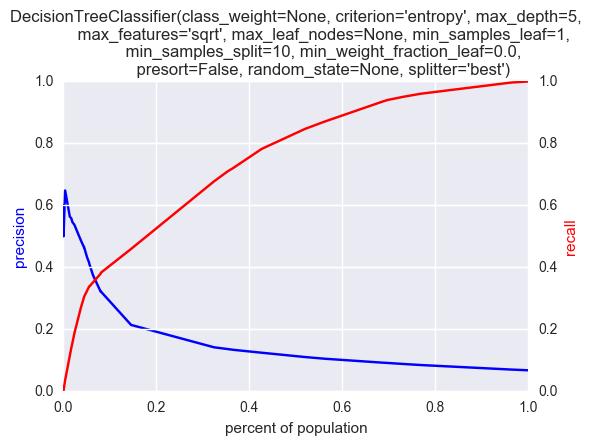

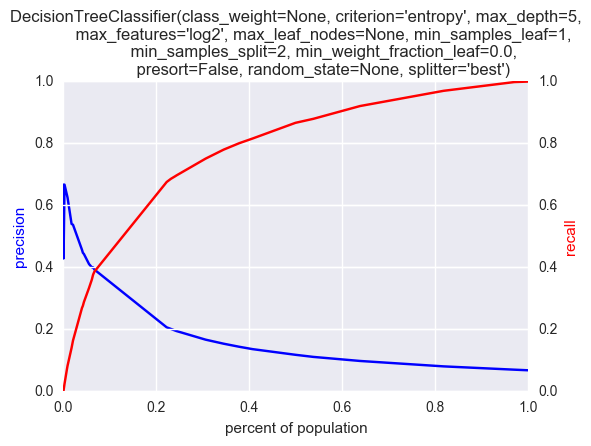

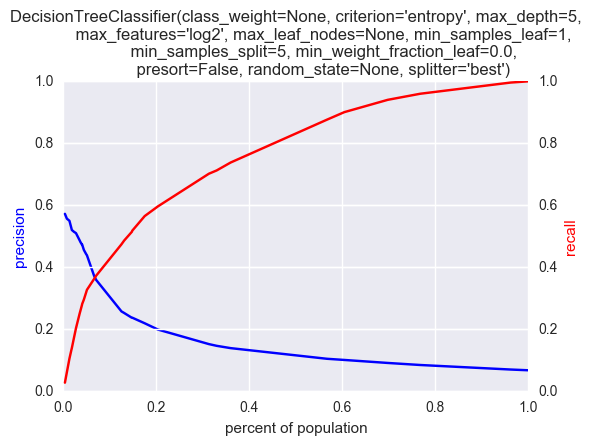

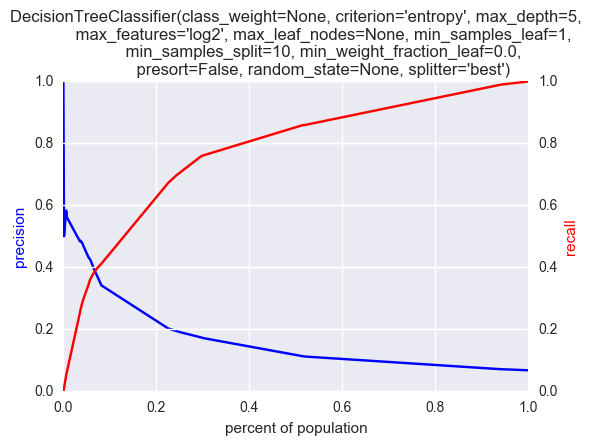

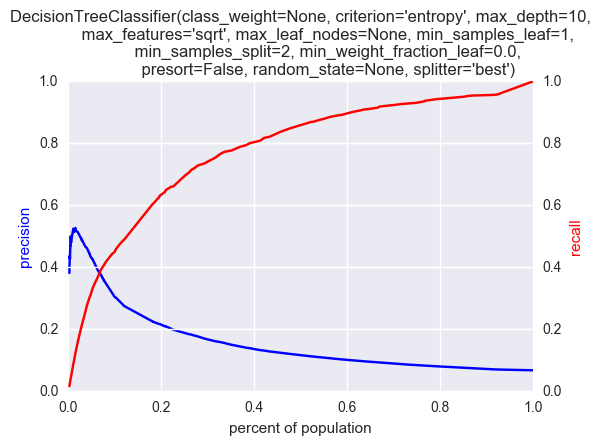

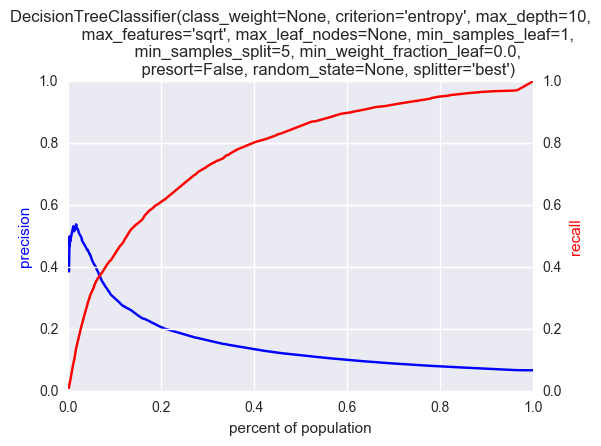

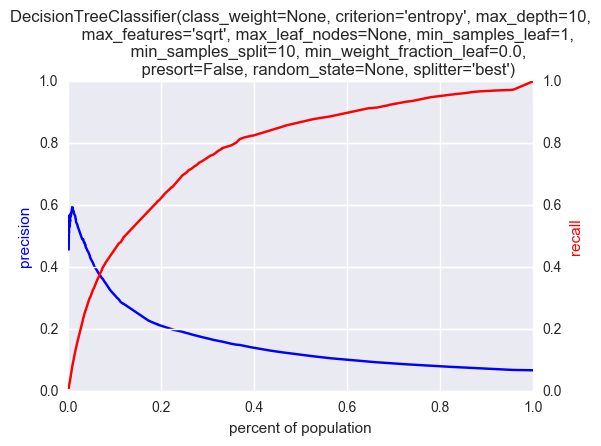

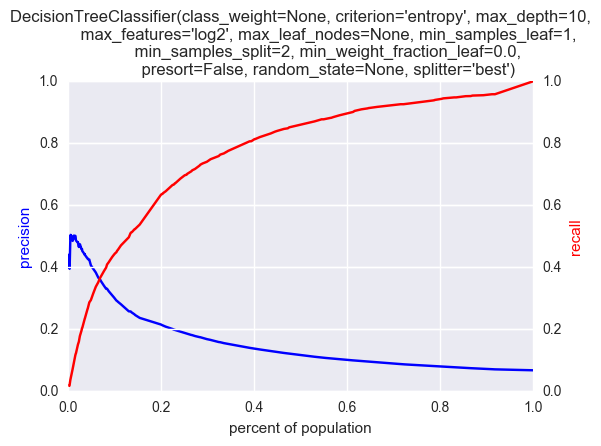

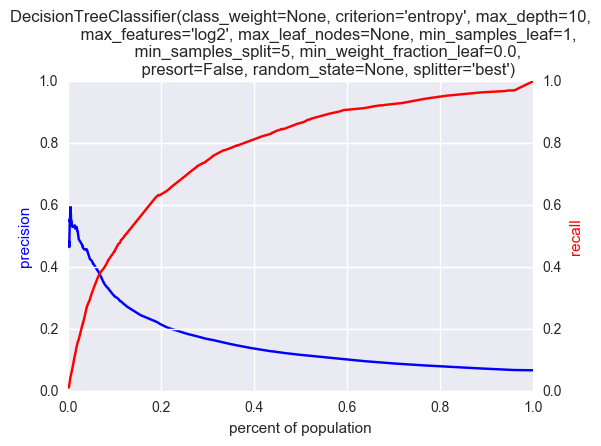

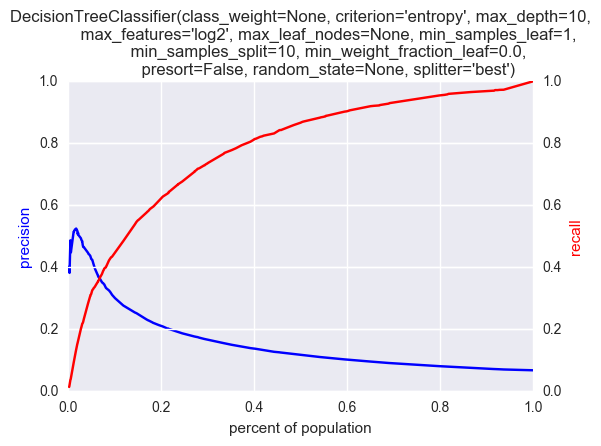

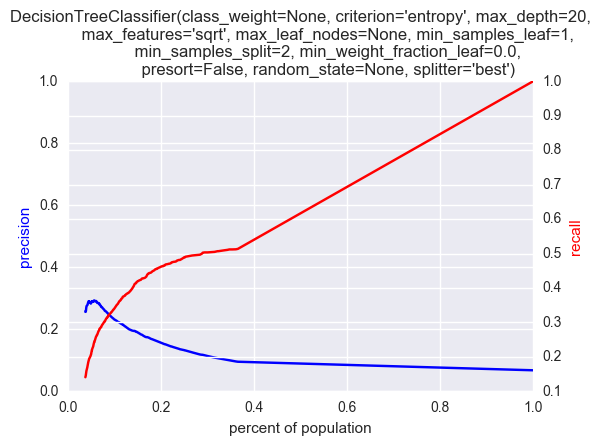

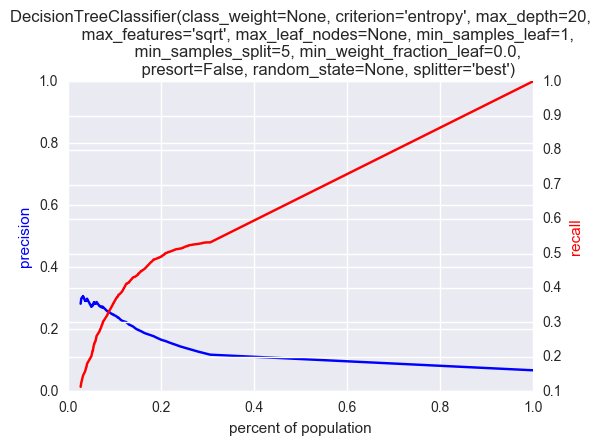

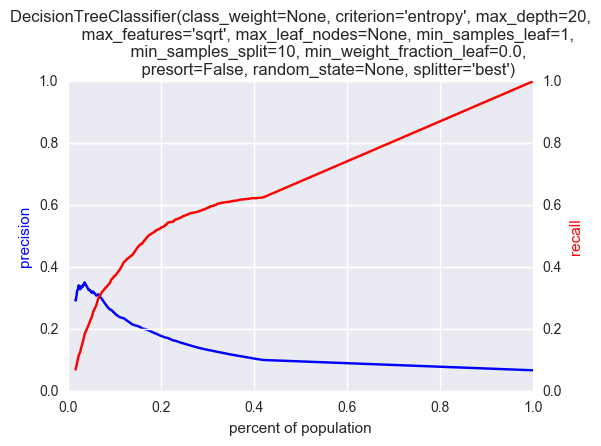

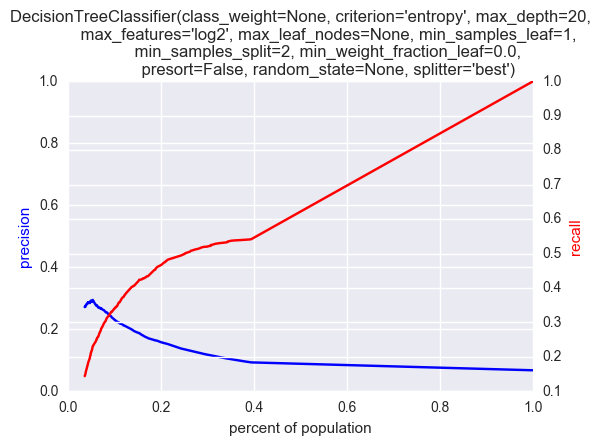

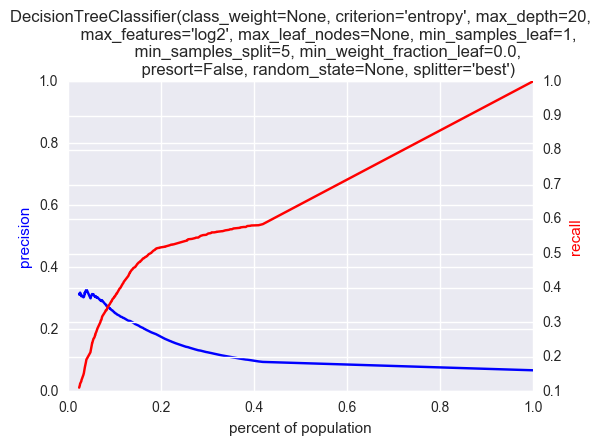

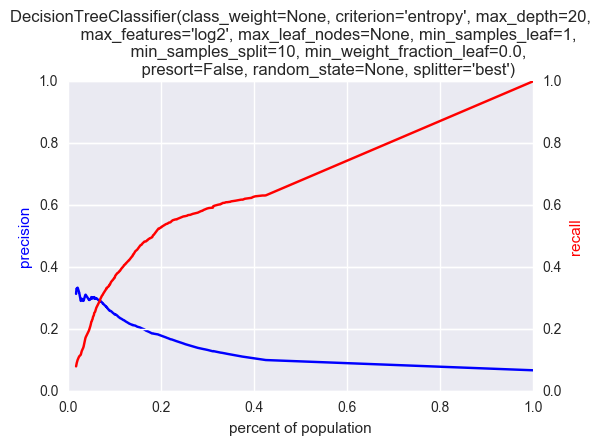

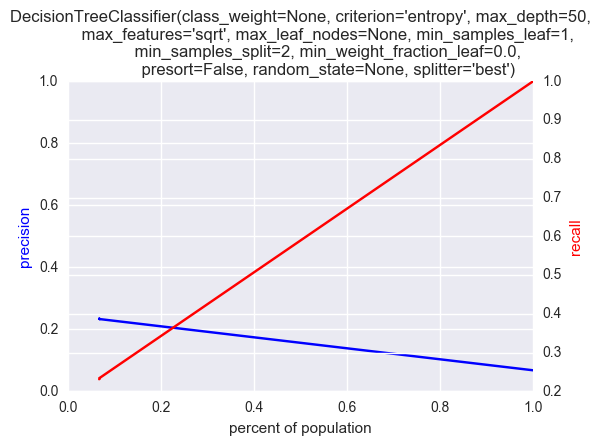

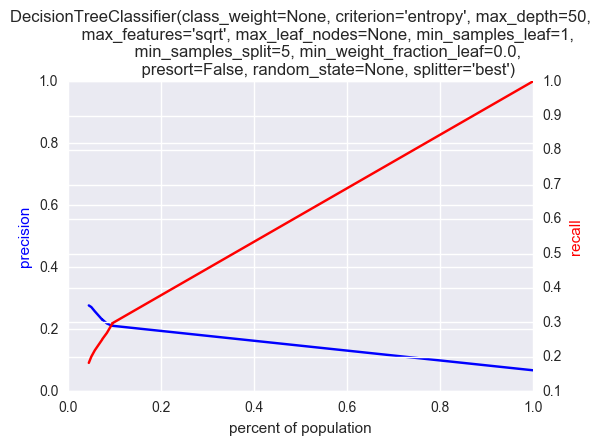

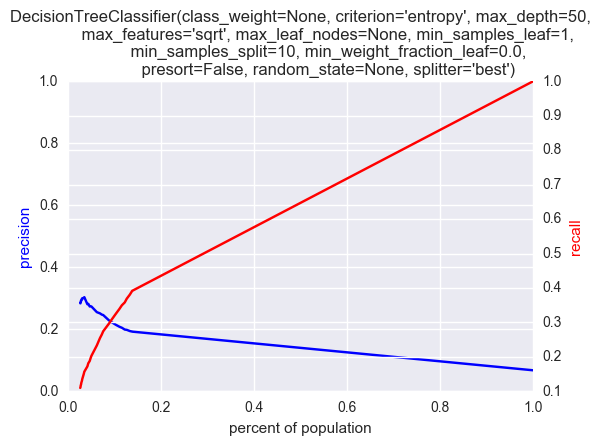

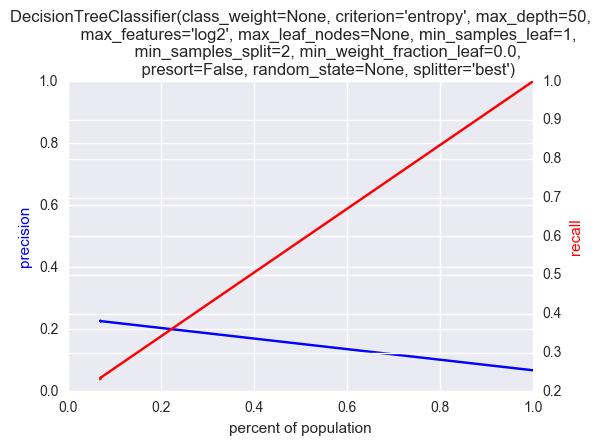

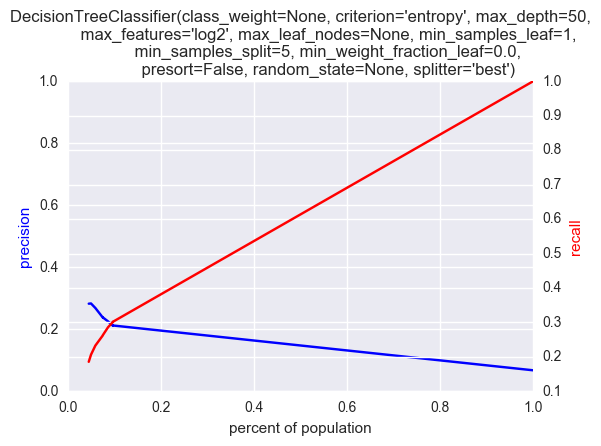

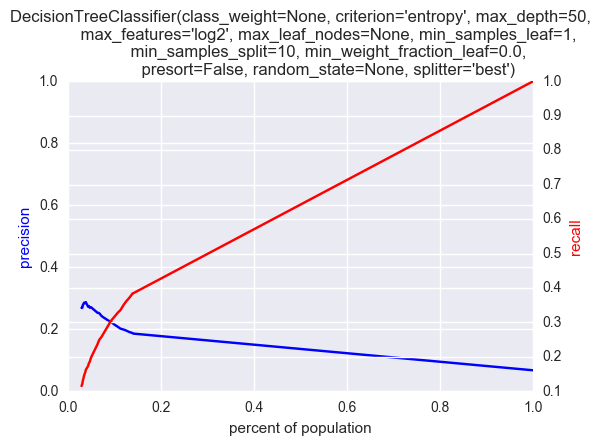

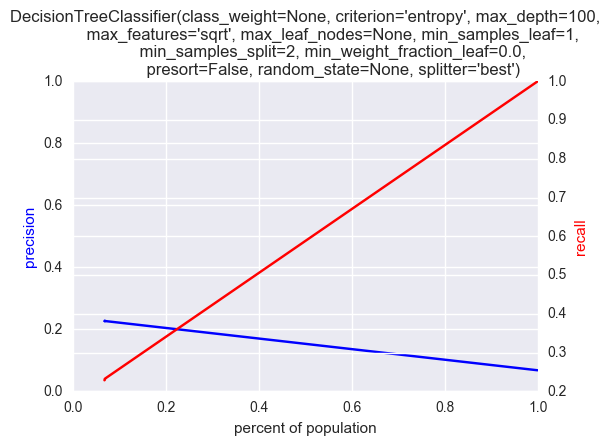

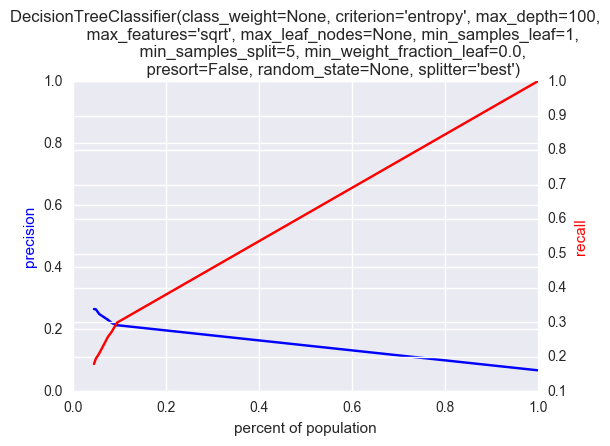

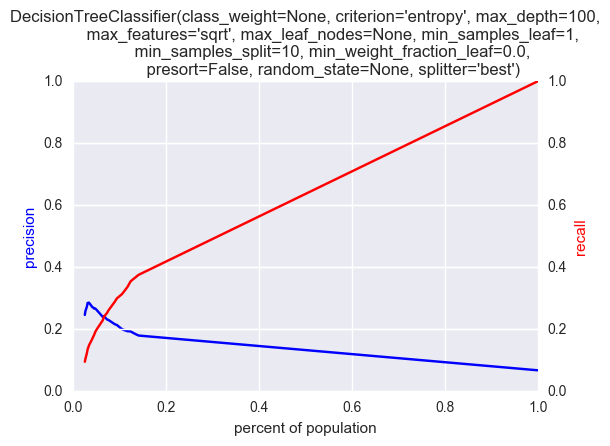

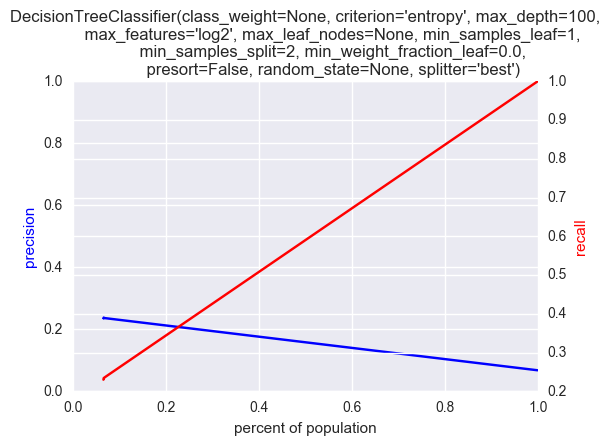

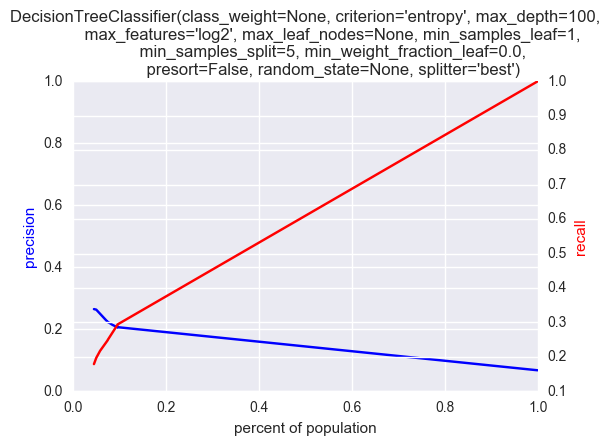

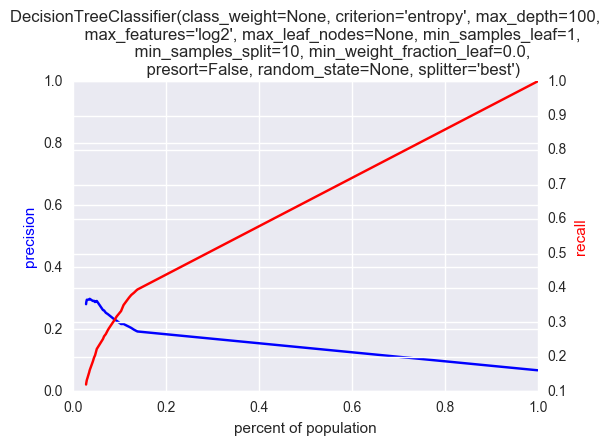

KNN


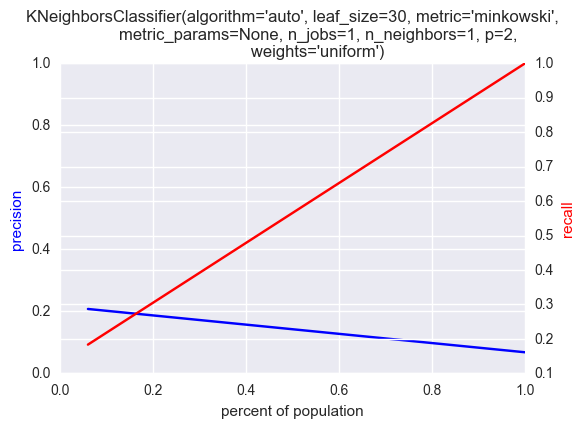

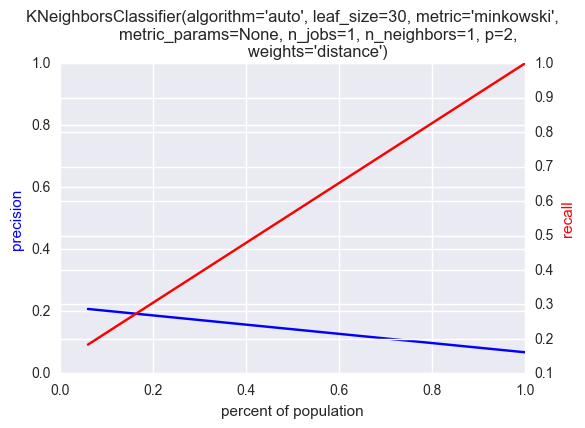

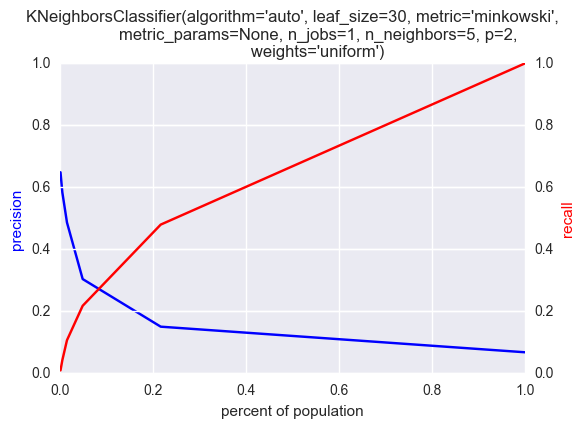

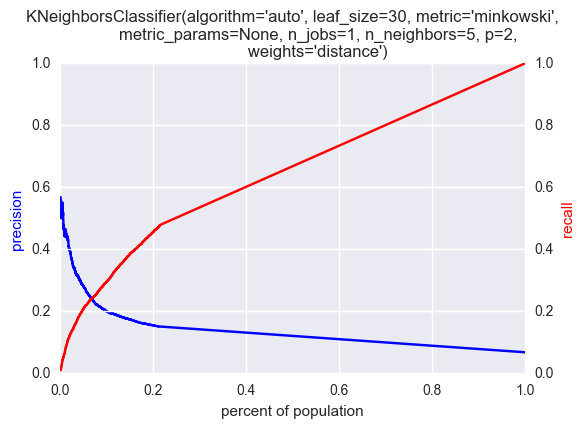

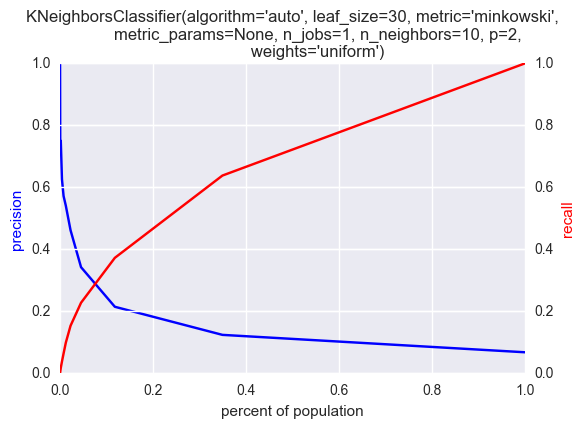

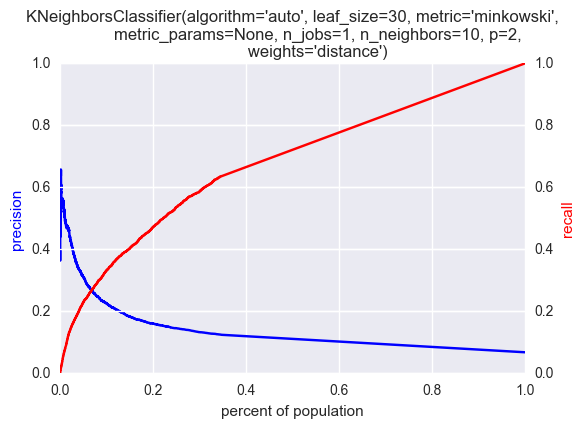

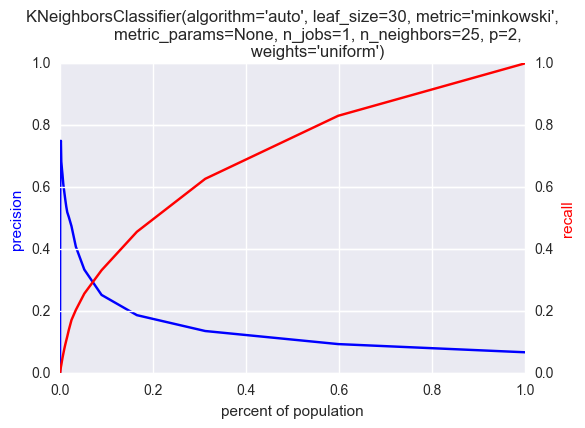

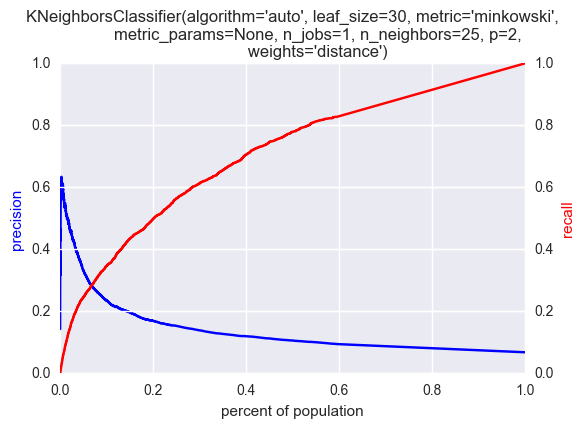

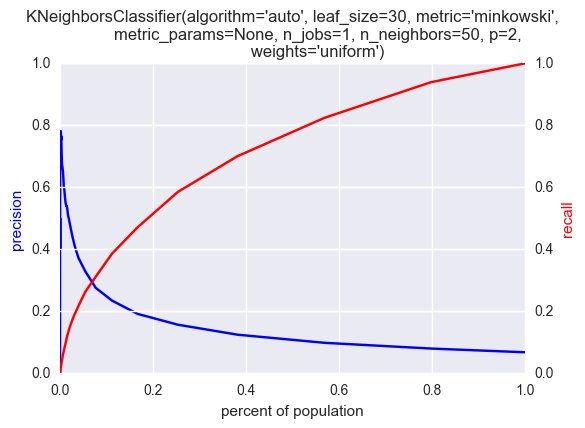

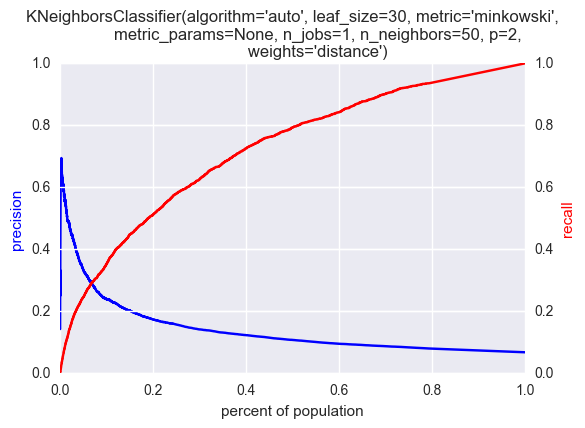

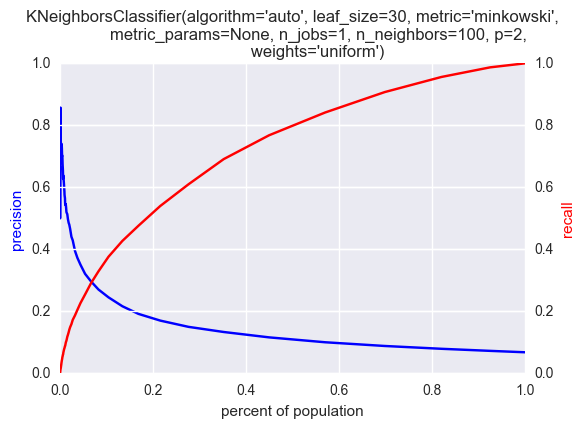

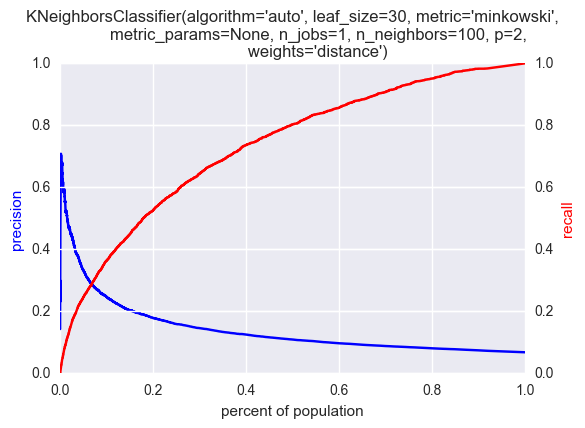

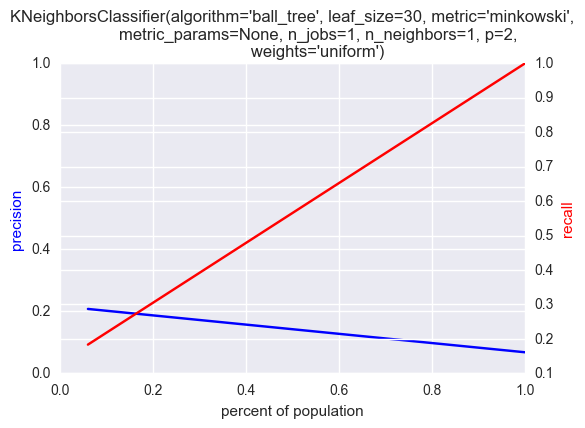

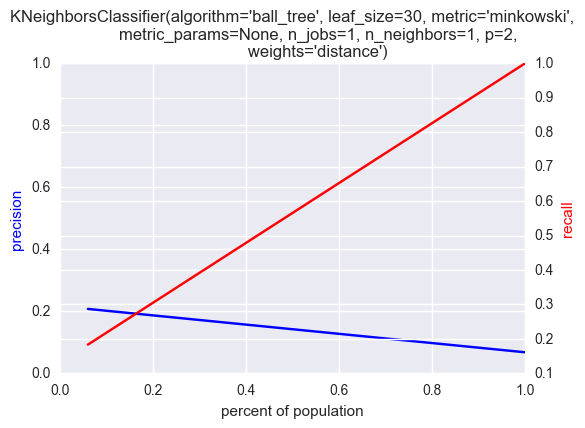

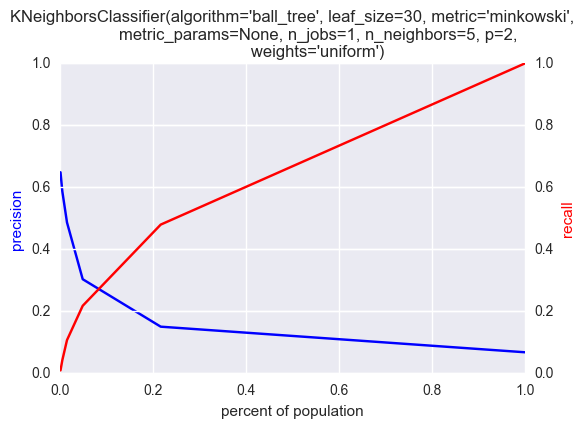

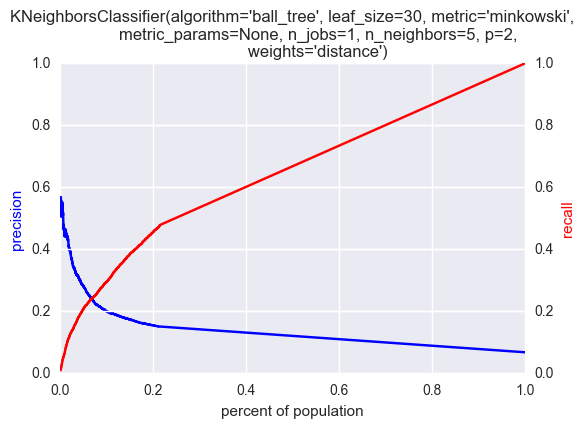

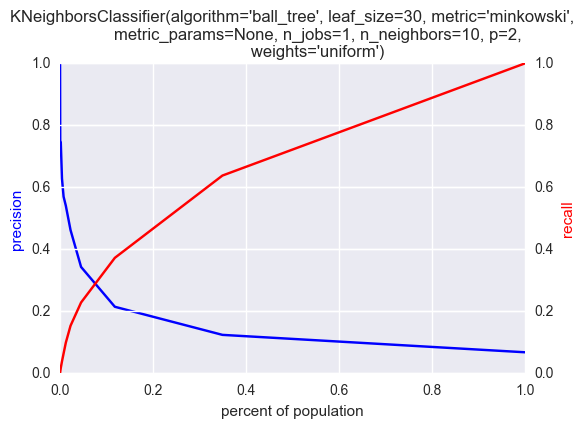

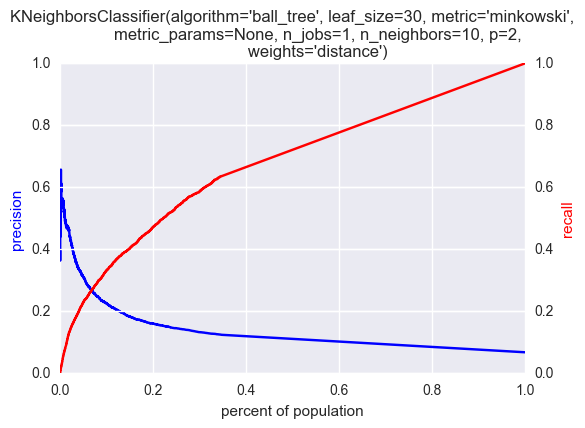

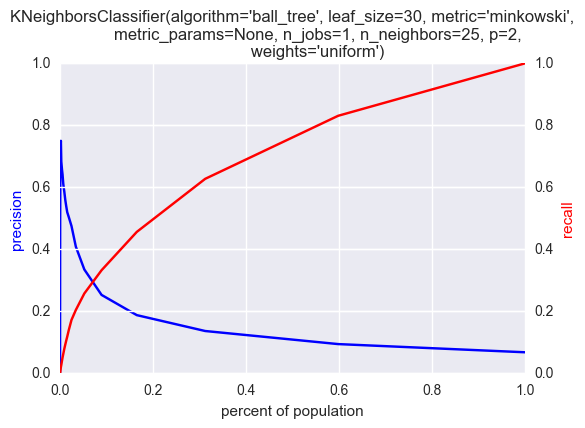

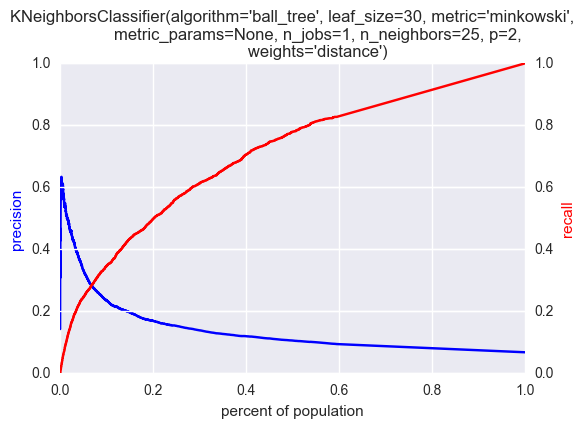

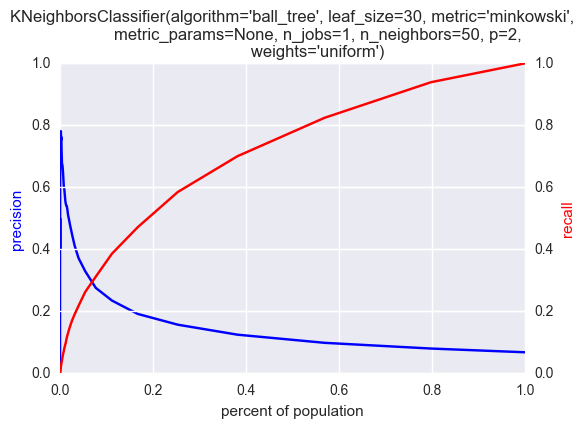

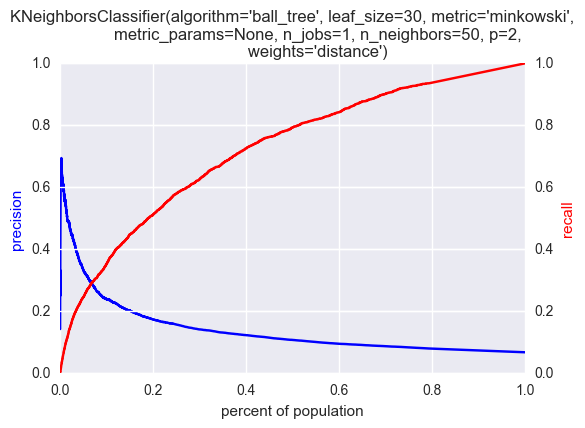

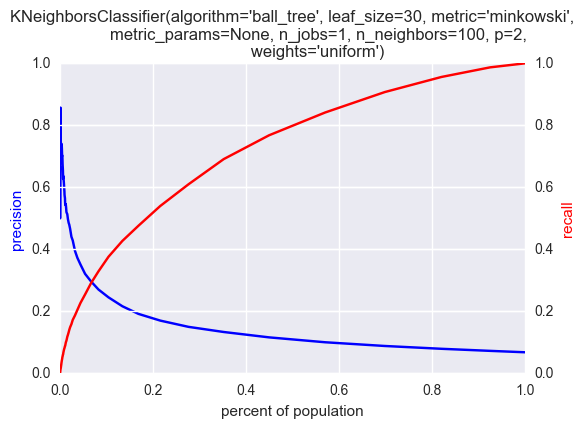

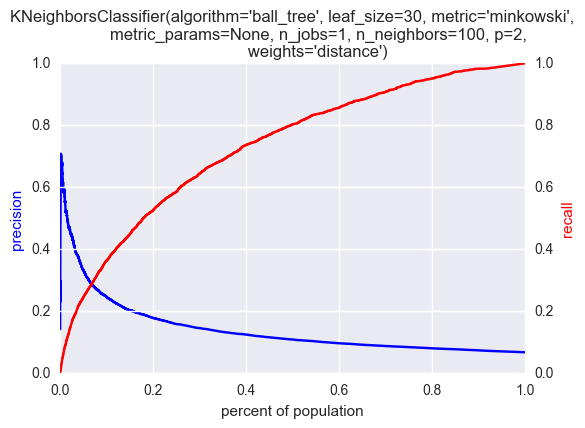

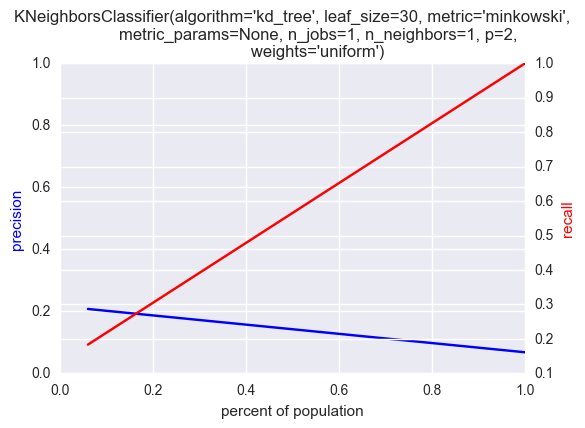

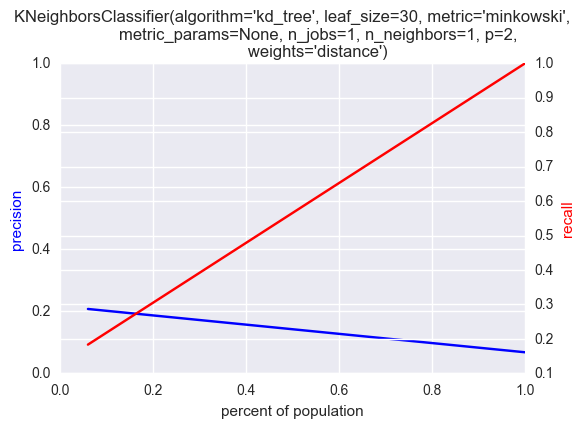

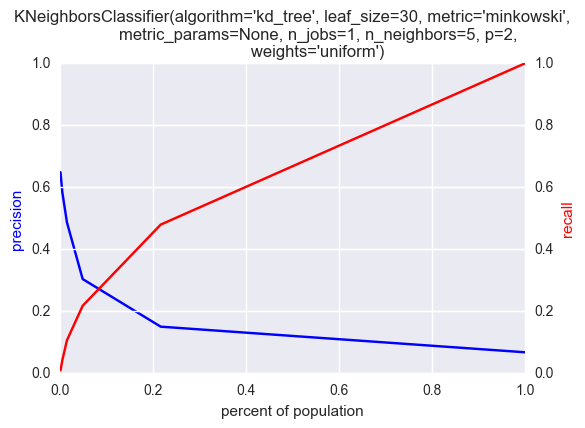

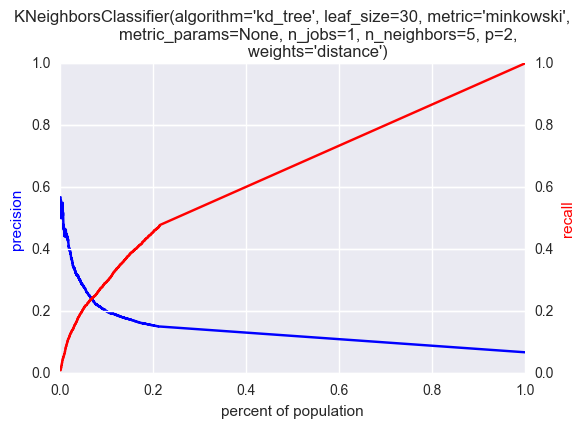

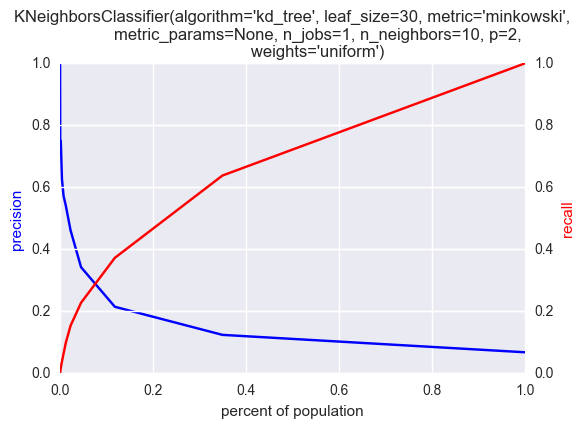

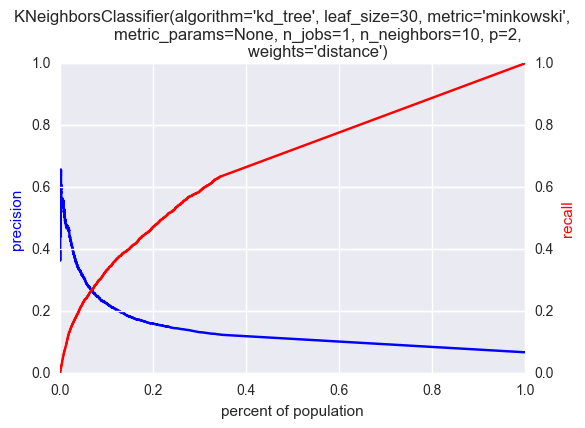

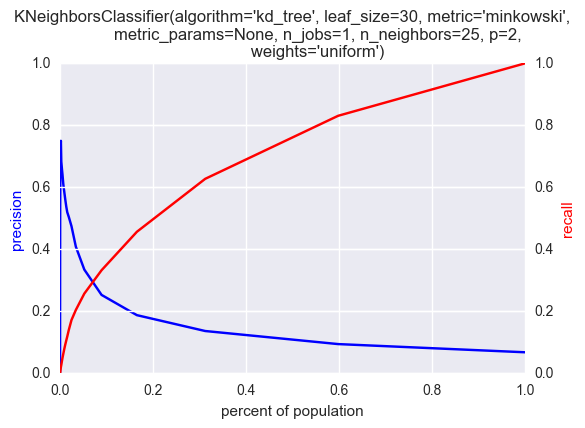

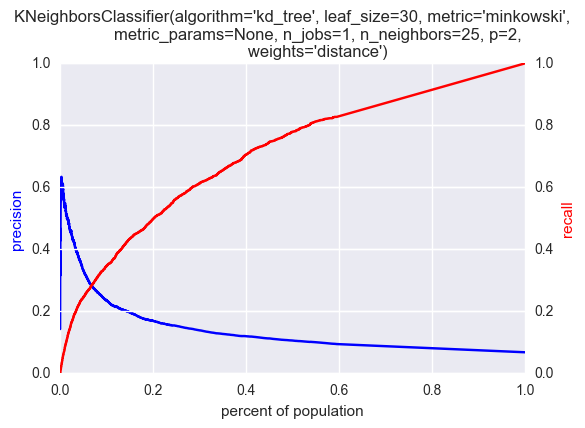

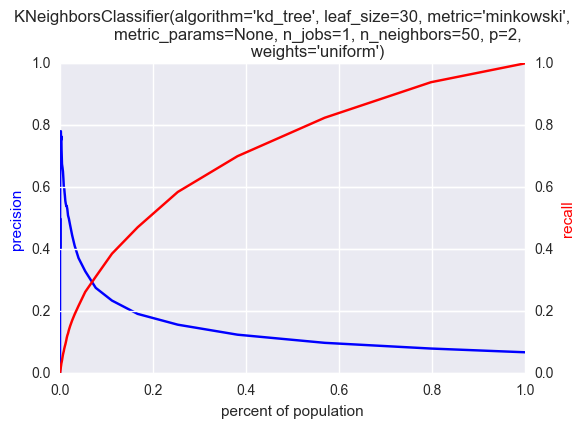

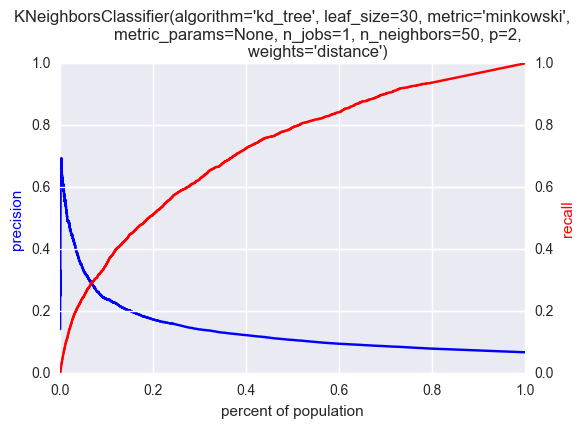

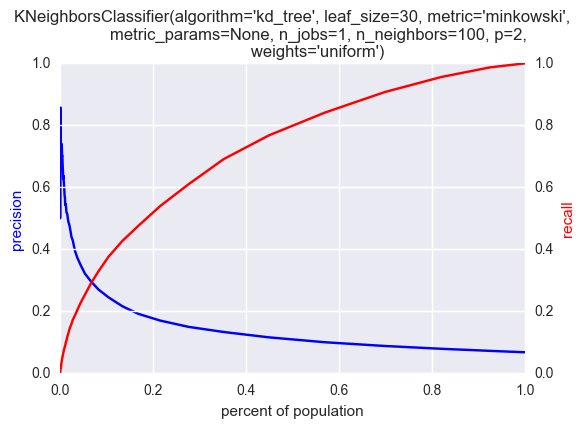

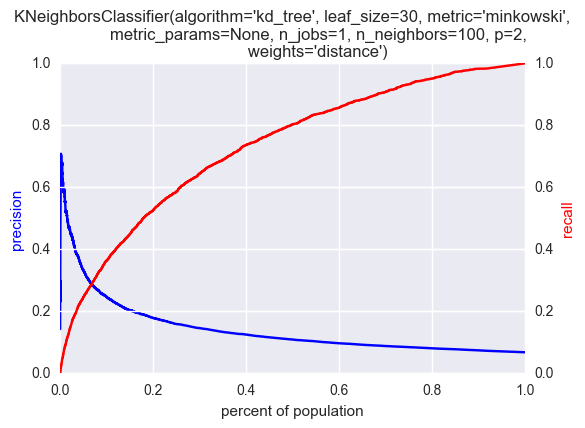

AB


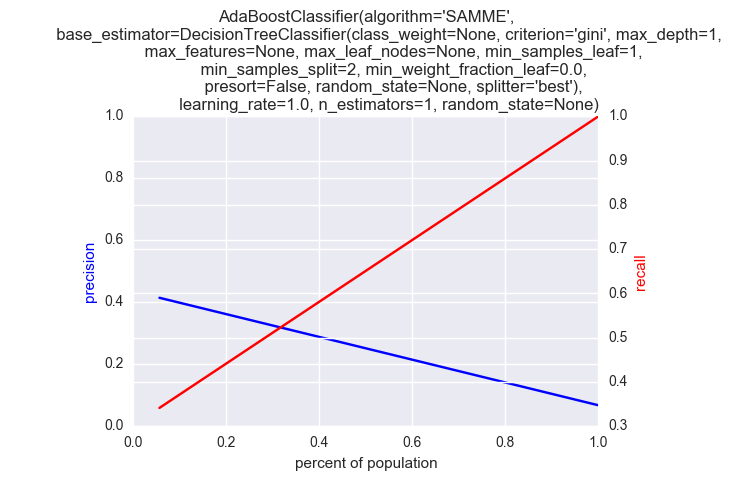

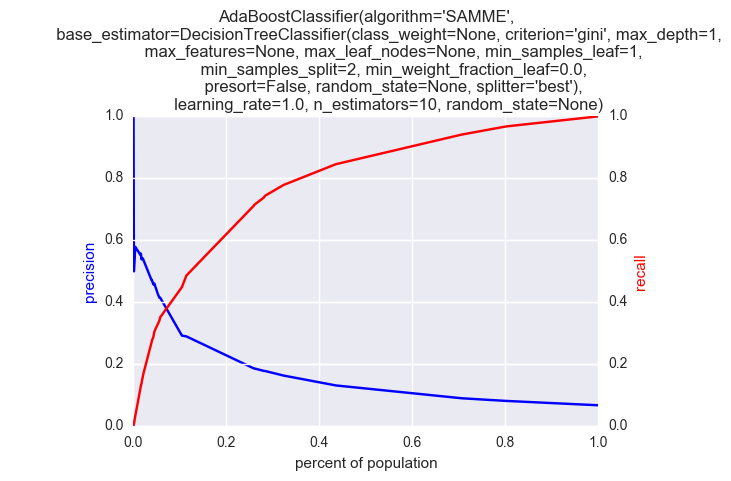

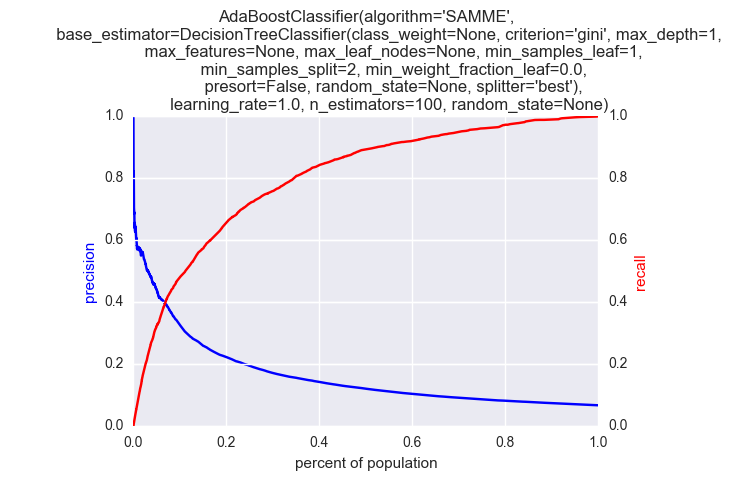

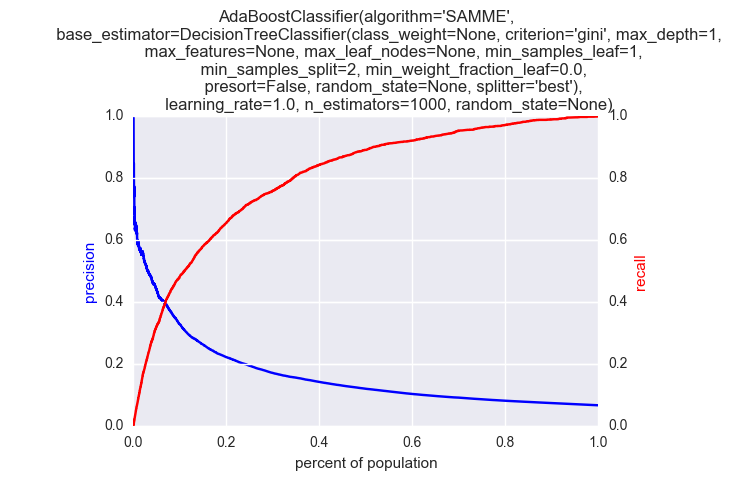

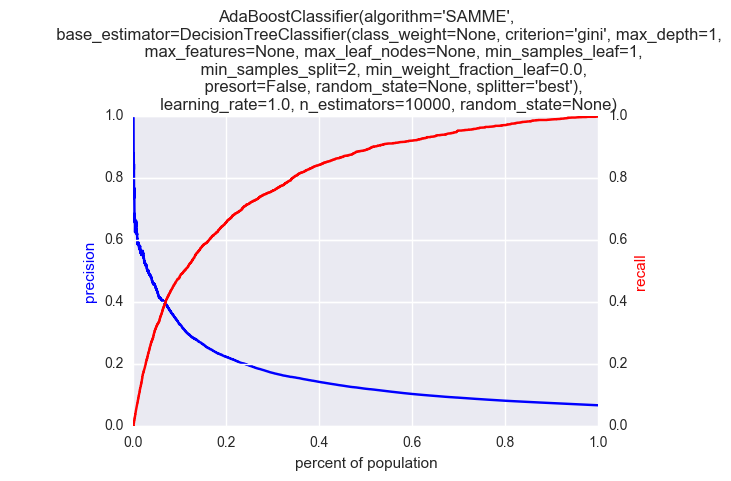

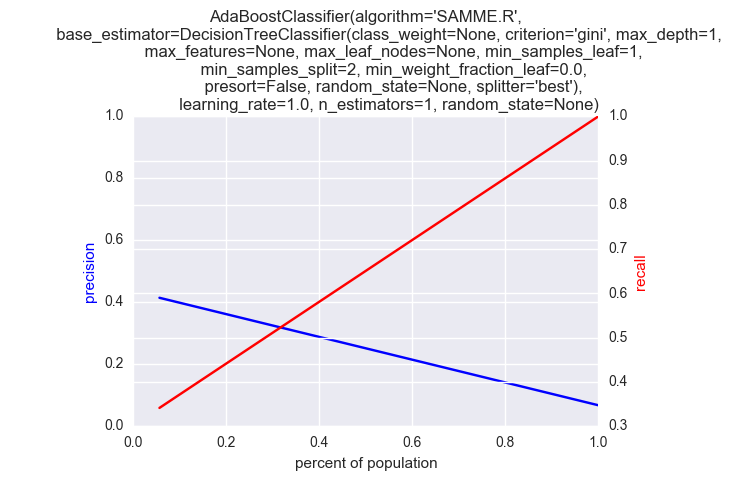

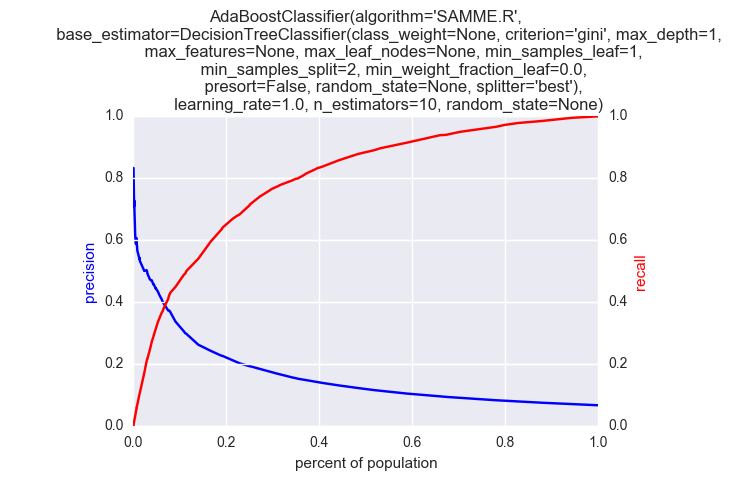

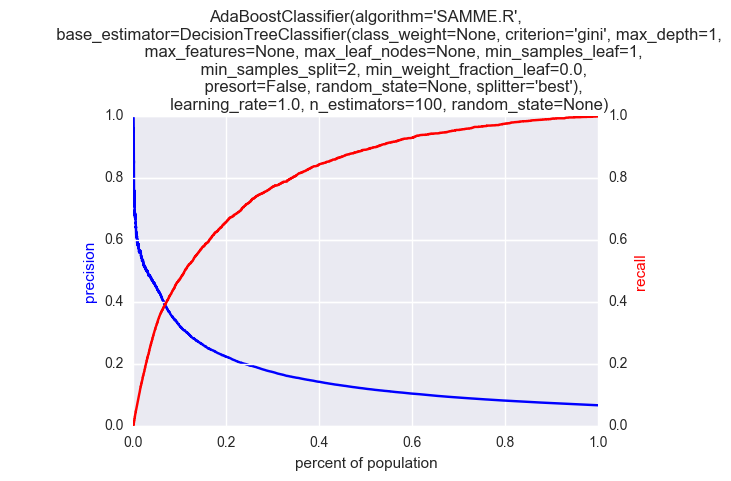

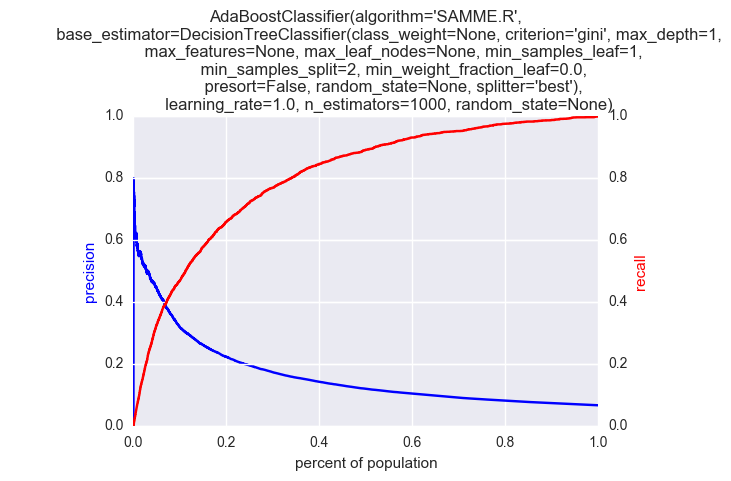

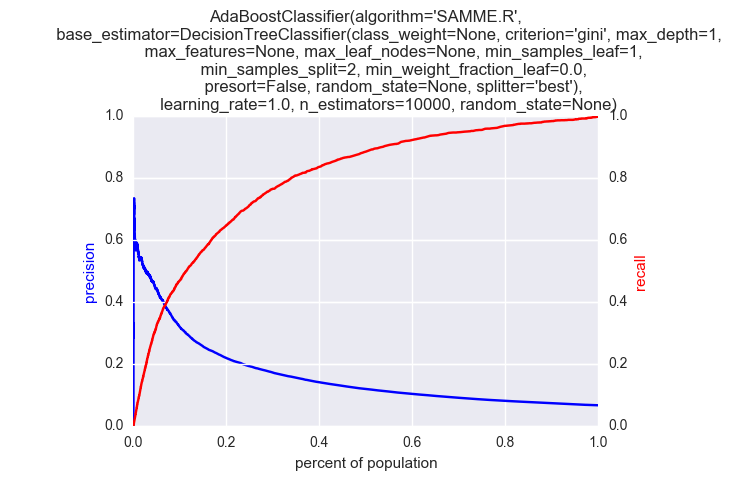

LR


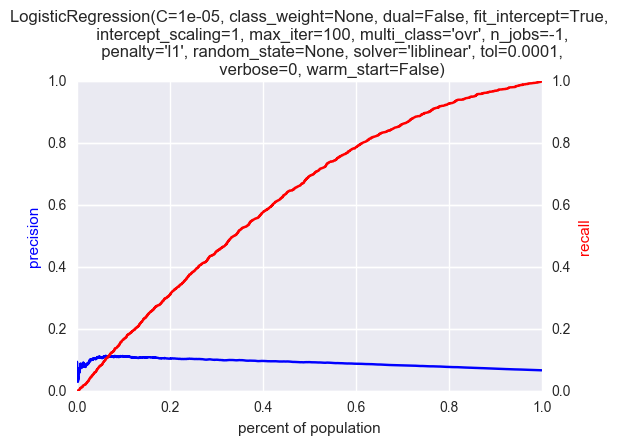

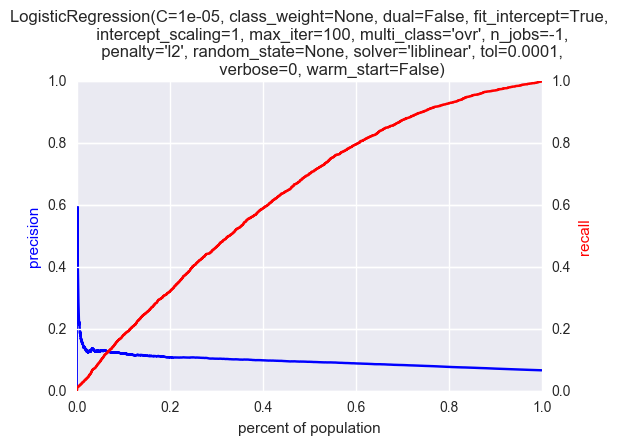

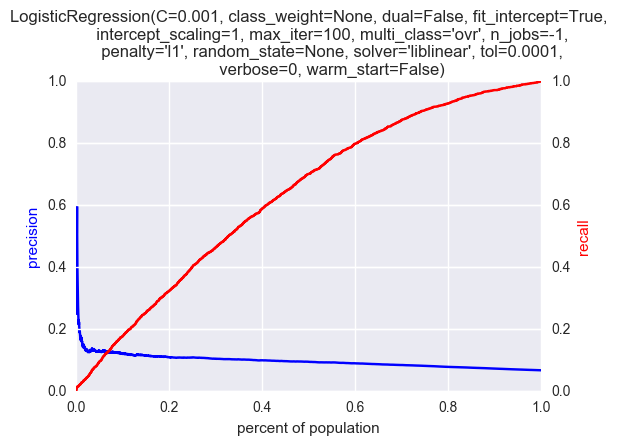

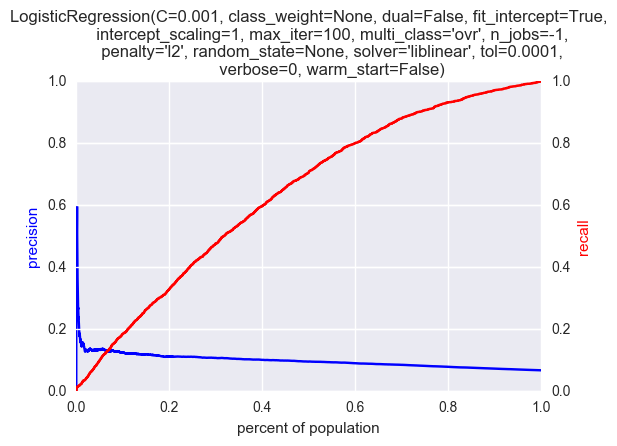

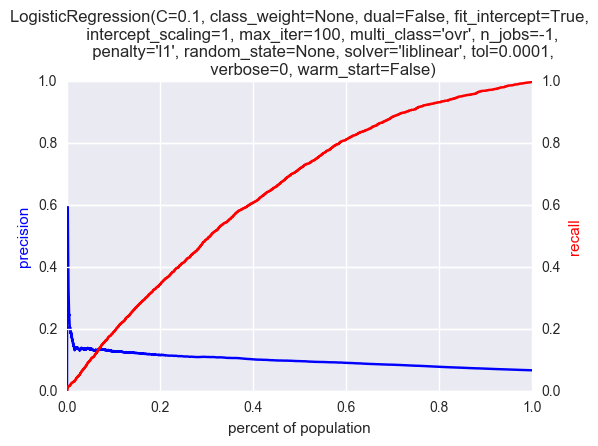

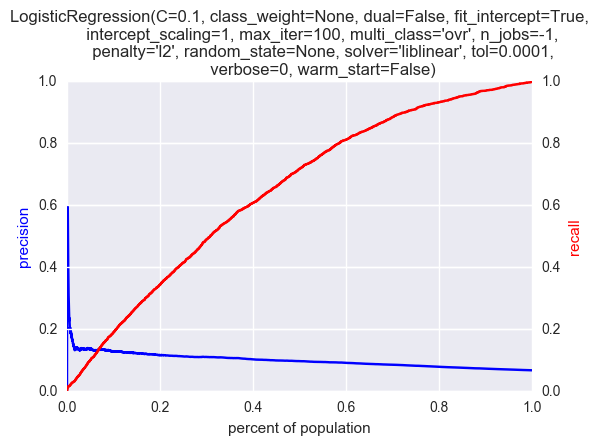

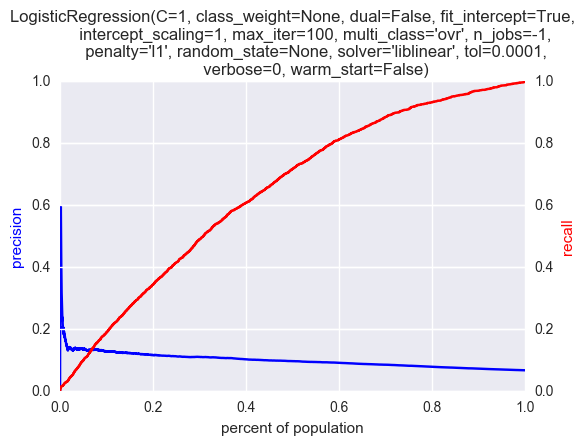

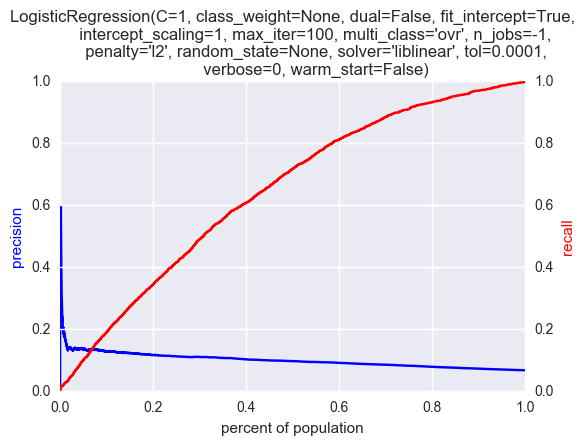

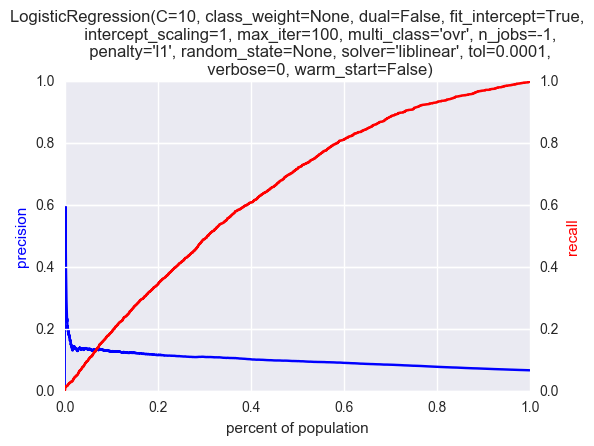

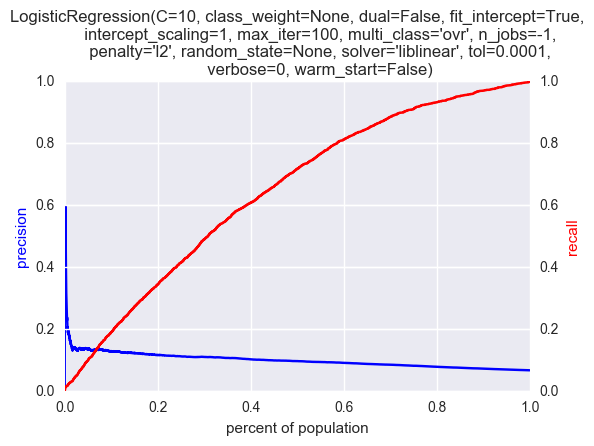

SVM


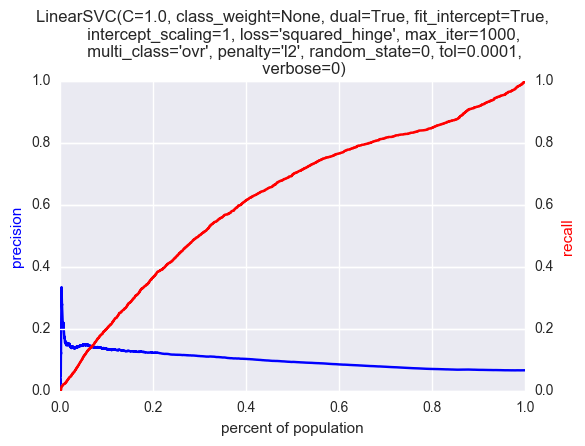

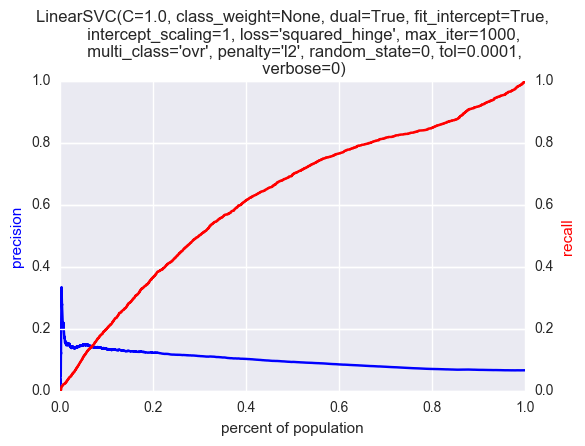

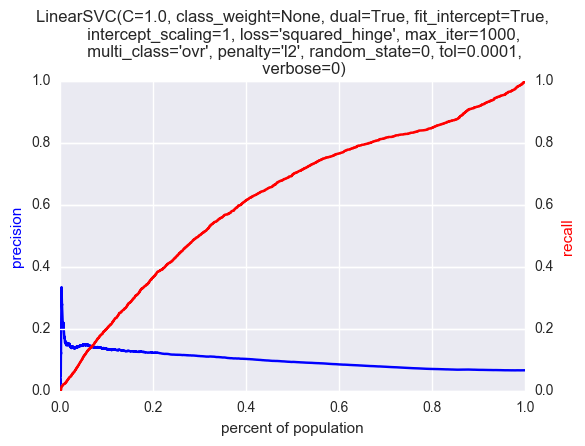

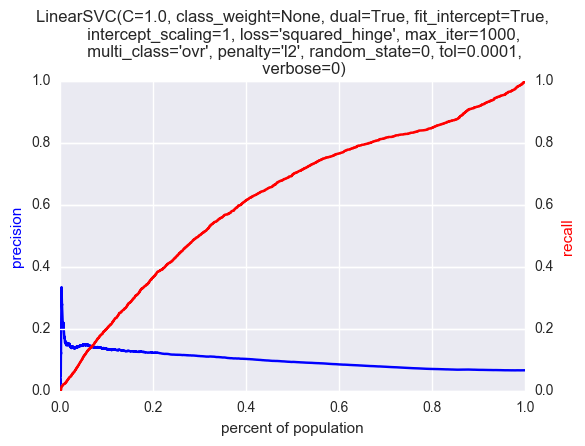

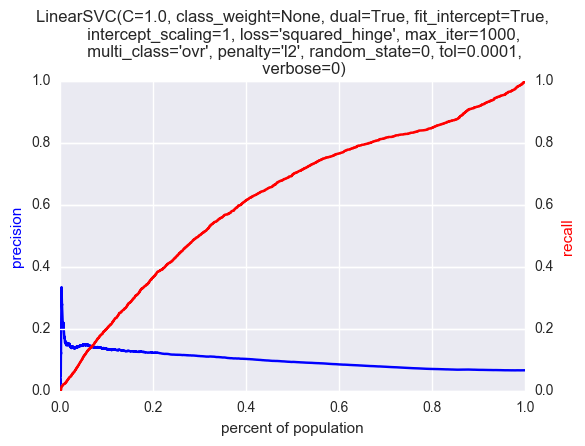

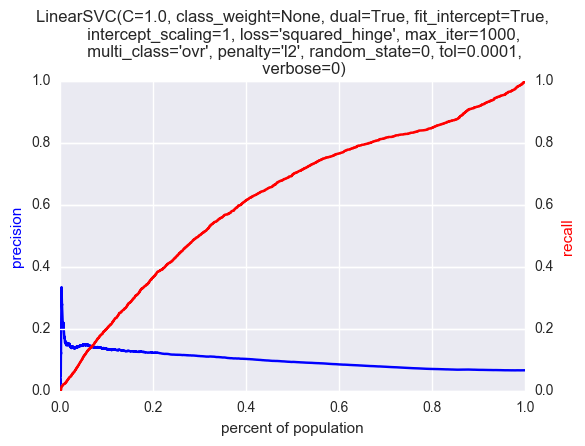

BAG


/Users/apple/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/Users/apple/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/Users/apple/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = o

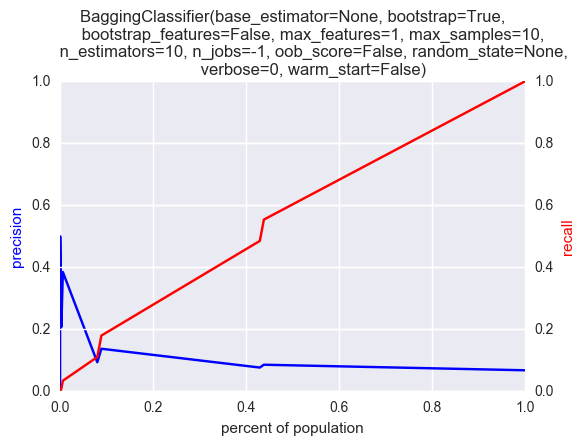

/Users/apple/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/Users/apple/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/Users/apple/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = o

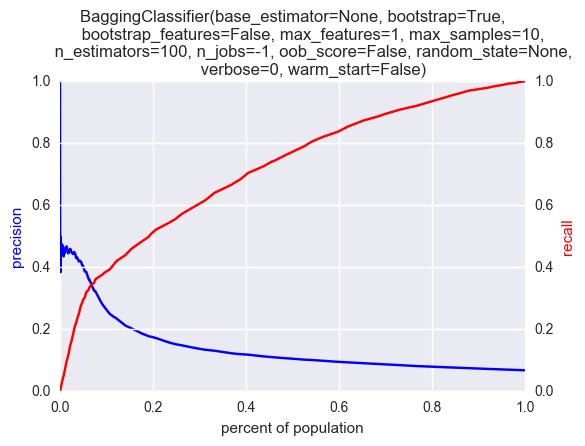

/Users/apple/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/Users/apple/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/Users/apple/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = o

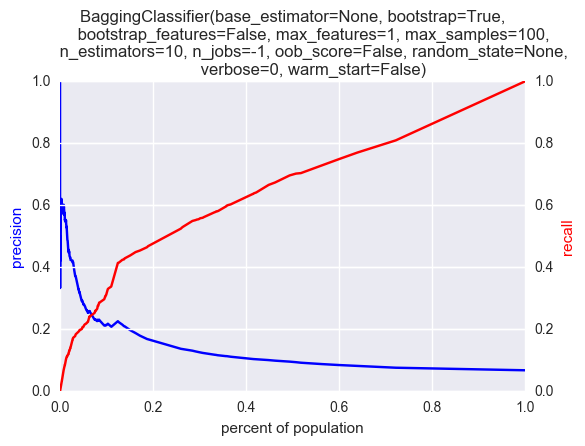

/Users/apple/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/Users/apple/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/Users/apple/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = o

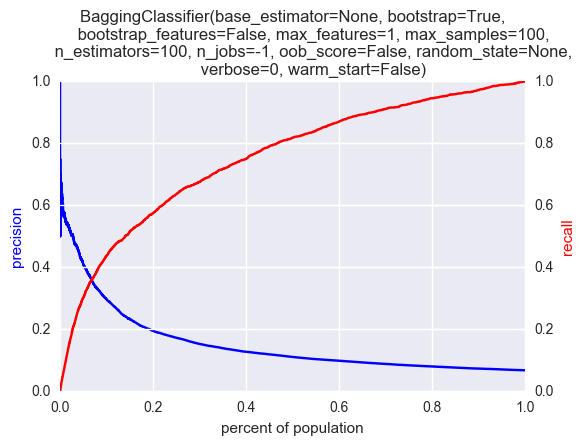

/Users/apple/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/Users/apple/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/Users/apple/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = o

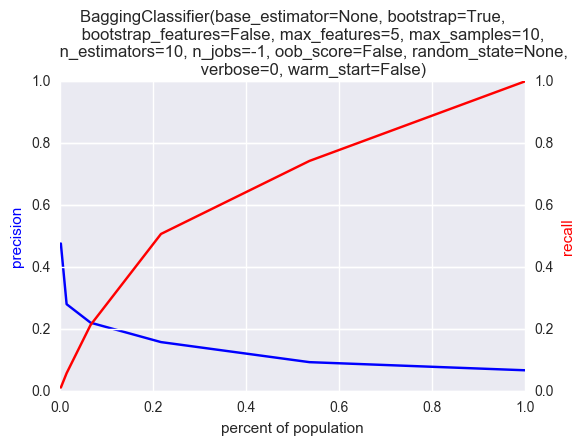

/Users/apple/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/Users/apple/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/Users/apple/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = o

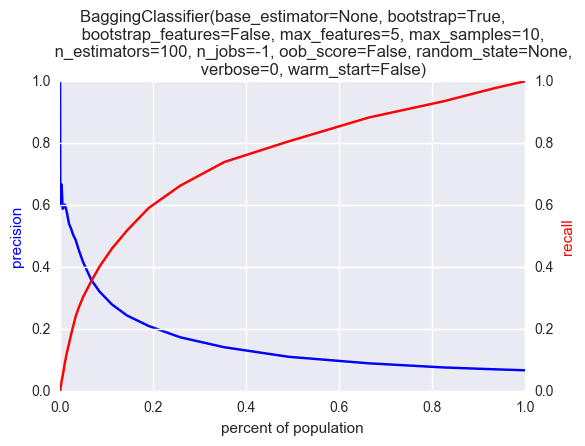

/Users/apple/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/Users/apple/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/Users/apple/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = o

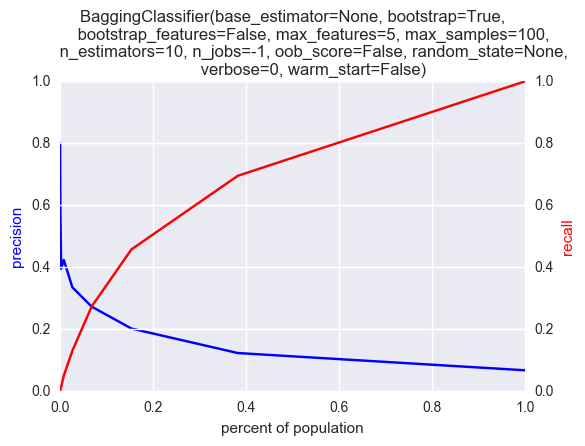

/Users/apple/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/Users/apple/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/Users/apple/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = o

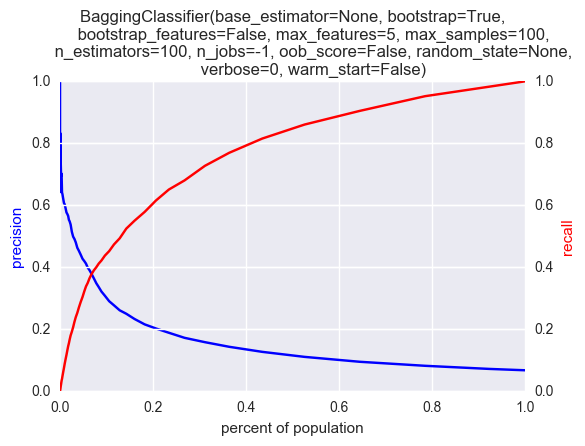

In [104]:
def define_clfs_params(grid_size):

    clfs = {'RF': RandomForestClassifier(n_estimators=50, n_jobs=-1),
        'ET': ExtraTreesClassifier(n_estimators=10, n_jobs=-1, criterion='entropy'),
        'AB': AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), algorithm="SAMME", n_estimators=200),
        'LR': LogisticRegression(penalty='l1', C=1e5, n_jobs=-1),
        'SVM': svm.LinearSVC(random_state=0),
        'GB': GradientBoostingClassifier(learning_rate=0.05, subsample=0.5, max_depth=6, n_estimators=10),
        'NB': GaussianNB(),
        'DT': DecisionTreeClassifier(),
        'SGD': SGDClassifier(loss="hinge", penalty="l2"),
        'KNN': KNeighborsClassifier(n_neighbors=3),
        'BAG': BaggingClassifier(n_jobs=-1)
            }

    large_grid = { 
    'RF':{'n_estimators': [1,10,100,1000,10000], 'max_depth': [1,5,10,20,50,100], 'max_features': ['sqrt','log2'],'min_samples_split': [2,5,10]},
    'LR': { 'penalty': ['l1','l2'], 'C': [0.00001,0.0001,0.001,0.01,0.1,1,10]},
    'SGD': { 'loss': ['hinge','log','perceptron'], 'penalty': ['l2','l1','elasticnet']},
    'ET': { 'n_estimators': [1,10,100,1000,10000], 'criterion' : ['gini', 'entropy'] ,'max_depth': [1,5,10,20,50,100], 'max_features': ['sqrt','log2'],'min_samples_split': [2,5,10]},
    'AB': { 'algorithm': ['SAMME', 'SAMME.R'], 'n_estimators': [1,10,100,1000,10000]},
    'GB': {'n_estimators': [1,10,100,1000,10000], 'learning_rate' : [0.001,0.01,0.05,0.1,0.5],'subsample' : [0.1,0.5,1.0], 'max_depth': [1,3,5,10,20,50,100]},
    'NB': {},
    'DT': {'criterion': ['gini', 'entropy'], 'max_depth': [1,5,10,20,50,100], 'max_features': ['sqrt','log2'],'min_samples_split': [2,5,10]},
    'SVM': {'C' :[0.00001,0.0001,0.001,0.01,0.1,1,10],'kernel':['linear']},
    'KNN': {'n_neighbors': [1,5,10,25,50,100],'weights': ['uniform','distance'],'algorithm': ['auto','ball_tree','kd_tree']},
    'BAG': {'n_estimators': [1,10,100,1000,1000], 'max_samples': [10,100,1000], 'max_features': [1,5,10]}
           }
    
    small_grid = { 
    'RF':{'n_estimators': [10,100], 'max_depth': [5,50], 'max_features': ['sqrt','log2'],'min_samples_split': [2,10]},
    'LR': { 'penalty': ['l1','l2'], 'C': [0.00001,0.001,0.1,1,10]},
#     'SGD': { 'loss': ['hinge','log','perceptron'], 'penalty': ['l2','l1','elasticnet']},
    'ET': { 'n_estimators': [10,100], 'criterion' : ['gini', 'entropy'] ,'max_depth': [5,50], 'max_features': ['sqrt','log2'],'min_samples_split': [2,10]},
    'AB': { 'algorithm': ['SAMME', 'SAMME.R'], 'n_estimators': [1,10,100,1000,10000]},
    'GB': {'n_estimators': [10,100], 'learning_rate' : [0.001,0.1,0.5],'subsample' : [0.1,0.5,1.0], 'max_depth': [5,50]},
    'NB' : {},
    'DT': {'criterion': ['gini', 'entropy'], 'max_depth': [1,5,10,20,50,100], 'max_features': ['sqrt','log2'],'min_samples_split': [2,5,10]},
    'SVM': {'C' :[0.1, 1, 10], 'penalty': ['l1','l2']},
    'KNN': {'n_neighbors': [1,5,10,25,50,100],'weights': ['uniform','distance'],'algorithm': ['auto','ball_tree','kd_tree']},
    'BAG': {'n_estimators': [10, 100], 'max_samples': [10, 100], 'max_features': [1, 5]}
           }
    
    test_grid = { 
    'RF':{'n_estimators': [1], 'max_depth': [1], 'max_features': ['sqrt'],'min_samples_split': [10]},
    'LR': { 'penalty': ['l1'], 'C': [0.01]},
#     'SGD': { 'loss': ['perceptron'], 'penalty': ['l2']},
    'ET': { 'n_estimators': [1], 'criterion' : ['gini'] ,'max_depth': [1], 'max_features': ['sqrt'],'min_samples_split': [10]},
    'AB': { 'algorithm': ['SAMME'], 'n_estimators': [1]},
    'GB': {'n_estimators': [1], 'learning_rate' : [0.1],'subsample' : [0.5], 'max_depth': [1]},
    'NB': {},
    'DT': {'criterion': ['gini'], 'max_depth': [1], 'max_features': ['sqrt'],'min_samples_split': [10]},
    'SVM': {'C' :[1], 'penalty': ['l2']},
    'KNN': {'n_neighbors': [5],'weights': ['uniform'],'algorithm': ['auto']},
    'BAG': {'n_estimators': [10], 'max_samples': [5], 'max_features': [5]}
           }
    
    if (grid_size == 'large'):
        return clfs, large_grid
    elif (grid_size == 'small'):
        return clfs, small_grid
    elif (grid_size == 'test'):
        return clfs, test_grid
    else:
        return 0, 0


def generate_binary_at_k(y_scores, k):
    cutoff_index = int(len(y_scores) * (k / 100.0))
    test_predictions_binary = [1 if x < cutoff_index else 0 for x in range(len(y_scores))]
    return test_predictions_binary


def metric_at_k(y_true, y_scores, k):
    '''
    Given a level of k, calculate corresponding precision, recall, and f1 scores.
    '''
    preds_at_k = generate_binary_at_k(y_scores, k)
    precision = precision_score(y_true, preds_at_k)
    recall = recall_score(y_true, preds_at_k)
    f1 = f1_score(y_true, preds_at_k)
    return precision, recall, f1


# def precision_at_k(y_true, y_scores, k):
#     preds_at_k = generate_binary_at_k(y_scores, k)
#     #precision, _, _, _ = metrics.precision_recall_fscore_support(y_true, preds_at_k)
#     #precision = precision[1]  # only interested in precision for label 1
#     precision = precision_score(y_true, preds_at_k)
#     return precision


def plot_precision_recall_n(y_true, y_prob, model_name):
    from sklearn.metrics import precision_recall_curve
    y_score = y_prob
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_score)
    precision_curve = precision_curve[:-1]
    recall_curve = recall_curve[:-1]
    pct_above_per_thresh = []
    number_scored = len(y_score)
    for value in pr_thresholds:
        num_above_thresh = len(y_score[y_score>=value])
        pct_above_thresh = num_above_thresh / float(number_scored)
        pct_above_per_thresh.append(pct_above_thresh)
    pct_above_per_thresh = np.array(pct_above_per_thresh)
    
    plt.clf()
    fig, ax1 = plt.subplots()
    ax1.plot(pct_above_per_thresh, precision_curve, 'b')
    ax1.set_xlabel('percent of population')
    ax1.set_ylabel('precision', color='b')
    ax2 = ax1.twinx()
    ax2.plot(pct_above_per_thresh, recall_curve, 'r')
    ax2.set_ylabel('recall', color='r')
    ax1.set_ylim([0,1])
    ax1.set_ylim([0,1])
    ax2.set_xlim([0,1])
    
    name = model_name
    plt.title(name)
    #plt.savefig(name)
    plt.show()


def clf_loop(models_to_run, clfs, grid, X, y):
    results_df =  pd.DataFrame(columns=('model_type',
                                        'clf',
                                        'accuracy',
                                        'time',
                                        'auc-roc',
                                        'p, r, f1_at_5',
                                        'p, r, f1_at_10',
                                        'p, r, f1_at_20'))
    for n in range(1, 2):
        # create training and valdation sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
        for index,clf in enumerate([clfs[x] for x in models_to_run]):
#             print("index=", index, 'clf type =', type(clf))
            print(models_to_run[index])
            parameter_values = grid[models_to_run[index]]
            for p in ParameterGrid(parameter_values):
                try:
                    start = time()
                    if hasattr(clf, "predict_proba"):
                        clf.set_params(**p)
                        y_pred_probs = clf.fit(X_train, y_train).predict_proba(X_test)[:,1]
                        
                        
                    else:  # use decision function
                        clf.fit(X_train, y_train)
                        prob_pos = clf.decision_function(X_test)
                        prob_pos = \
                            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
                        y_pred_probs = prob_pos
                    
                    accuracy = clf.score(X_test, y_test)
                    end = time()
                    delta_time = end - start
                    # you can also store the model, feature importances, and prediction scores
                    # we're only storing the metrics for now
                    y_pred_probs_sorted, y_test_sorted = zip(*sorted(zip(y_pred_probs, y_test), reverse=True))
                    results_df.loc[len(results_df)] = [models_to_run[index],
                                                       clf,
                                                       accuracy,
                                                       delta_time,
                                                       roc_auc_score(y_test, y_pred_probs),
                                                       metric_at_k(y_test_sorted,y_pred_probs_sorted,5.0),
                                                       metric_at_k(y_test_sorted,y_pred_probs_sorted,10.0),
                                                       metric_at_k(y_test_sorted,y_pred_probs_sorted,20.0)]
                    
                    if NOTEBOOK == 1:
                        plot_precision_recall_n(y_test, y_pred_probs, clf)
                except IndexError:
                    print('Error:', e)
                    continue
    return results_df



def main():

    grid_size = 'small'
    clfs, grid = define_clfs_params(grid_size)
    models_to_run=['RF','DT','KNN', 'AB', 'LR', 'SVM', 'BAG']#, 'NB', 'ET', 'GB',

    df = pd.read_csv('/Users/apple/GitHub/machine_learning_works/hw2/credit-data.csv')
    df.columns = [camel_to_snake(col) for col in df.columns]
    preprocess_data(df.monthly_income, df.monthly_income.median())
    preprocess_data(df.number_of_dependents, 0)
    
    X = df.drop(['serious_dlqin2yrs','person_id'], axis=1)
    scaler = RobustScaler()
    df['monthly_income_scaled'] = scaler.fit_transform(X['monthly_income'].values.reshape(-1,1))
    df['debt_ratio_scaled'] = scaler.fit_transform(X['debt_ratio'].values.reshape(-1,1))

    
    features = ['revolving_utilization_of_unsecured_lines',
                'age',
                'debt_ratio_scaled',
                'number_of_times90_days_late',
                'monthly_income_scaled',
                'number_of_open_credit_lines_and_loans']
    X = df[features]
    y = df.serious_dlqin2yrs
    results_df = clf_loop(models_to_run, clfs, grid, X, y)
    
    
    if NOTEBOOK == 1:
        results_df
    results_df.to_csv('results.csv', index=False)
    return results_df

if __name__ == '__main__':
    main()


RF


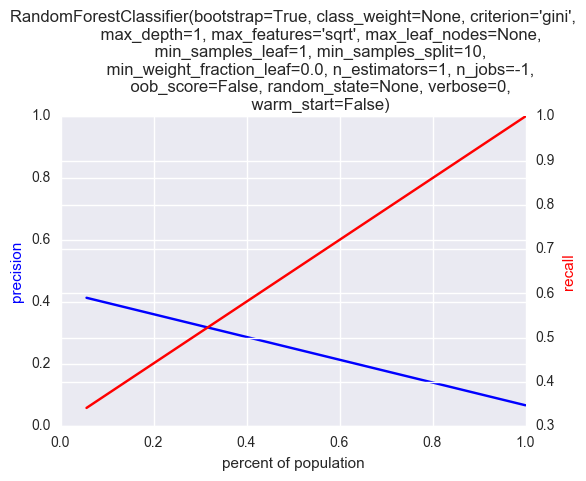

DT


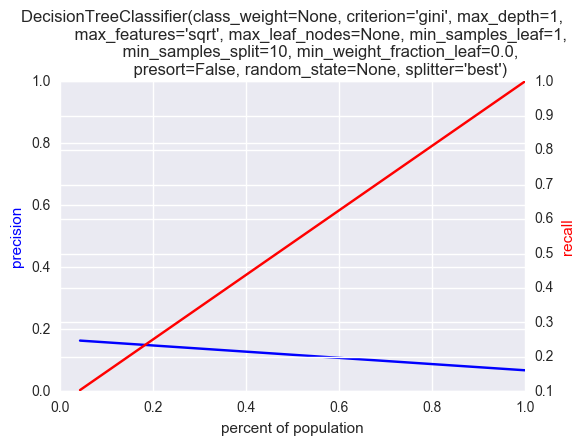

KNN


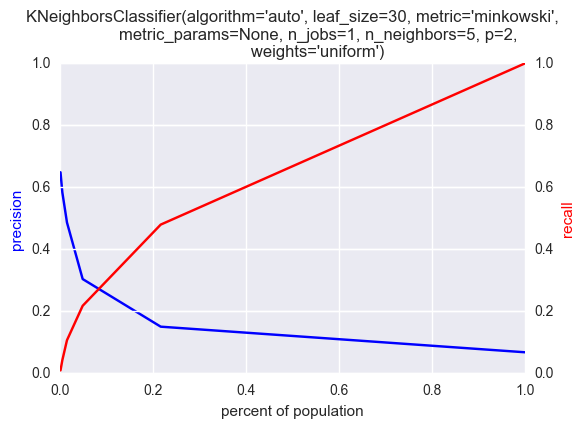

AB


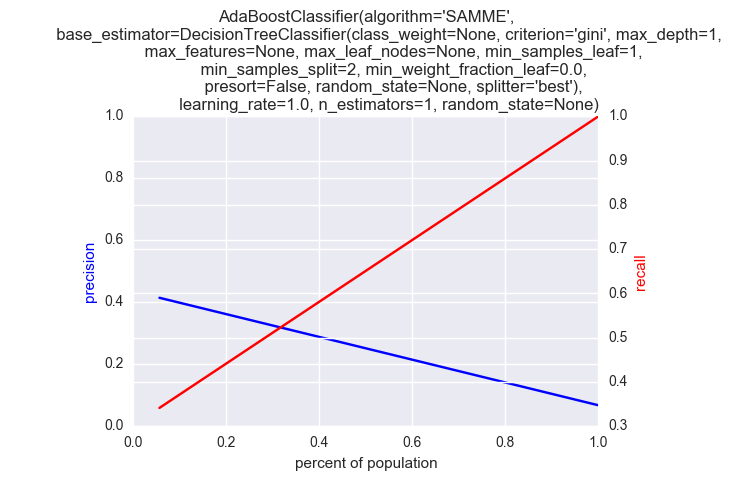

LR


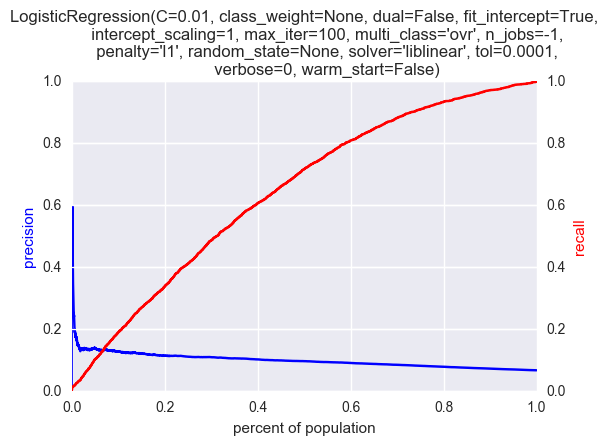

SVM


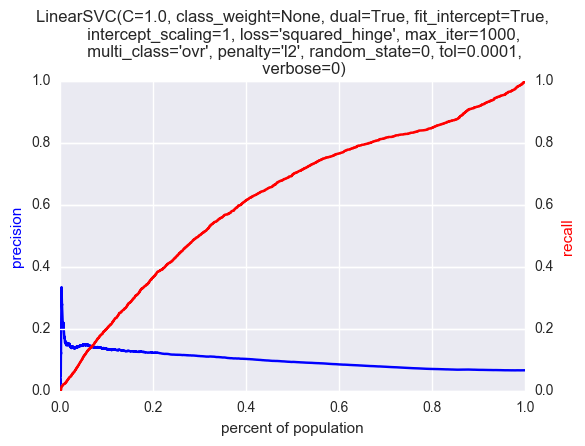

BAG


/Users/apple/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/Users/apple/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/Users/apple/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = o

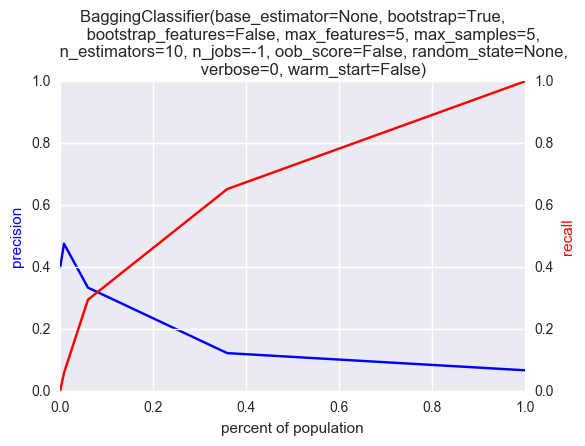

In [99]:
results_df = main()

## Pipeline 6 of 6: Evaluation

In [101]:
best = results_df.groupby(['model_type'])['auc-roc'].transform(max) == results_df['auc-roc']

In [103]:
results_df[best]

model_type                                                clf  \
0         RF  (DecisionTreeClassifier(class_weight=None, cri...   
1         DT  DecisionTreeClassifier(class_weight=None, crit...   
2        KNN  KNeighborsClassifier(algorithm='auto', leaf_si...   
3         AB  (DecisionTreeClassifier(class_weight=None, cri...   
4         LR  LogisticRegression(C=0.01, class_weight=None, ...   
5        SVM  LinearSVC(C=1.0, class_weight=None, dual=True,...   
6        BAG  (DecisionTreeClassifier(class_weight=None, cri...   

                                          parameters  \
0  (DecisionTreeClassifier(class_weight=None, cri...   
1  DecisionTreeClassifier(class_weight=None, crit...   
2  KNeighborsClassifier(algorithm='auto', leaf_si...   
3  (DecisionTreeClassifier(class_weight=None, cri...   
4  LogisticRegression(C=0.01, class_weight=None, ...   
5  LinearSVC(C=1.0, class_weight=None, dual=True,...   
6  (DecisionTreeClassifier(class_weight=None, cri...   

                                            accuracy       time   auc-roc  \
0  {'min_samples_split': 10, 'max_depth': 1, 'max...   0.229363  0.653223   
1  {'criterion': 'gini', 'min_samples_split': 10,...   0.052084  0.532528   
2  {'weights': 'uniform', 'algorithm': 'auto', 'n...   1.899878  0.655116   
3          {'n_estimators': 1, 'algorithm': 'SAMME'}   0.095488  0.653223   
4                       {'penalty': 'l1', 'C': 0.01}   0.408189  0.654683   
5                          {'penalty': 'l2', 'C': 1}  21.045018  0.633845   
6  {'n_estimators': 10, 'max_features': 5, 'max_s...   0.698814  0.693724   

                                      p, r, f1_at_5  \
0           (0.464, 0.341578327444, 0.393487109905)   
1  (0.280533333333, 0.206517471535, 0.237901402081)   
2  (0.322666666667, 0.237534354142, 0.273631840796)   
3           (0.464, 0.341578327444, 0.393487109905)   
4   (0.140266666667, 0.103258735768, 0.11895070104)   
5  (0.150933333333, 0.111111111111, 0.127996381728)   
6          (0.4016, 0.295641931684, 0.340569877883)   

                                     p, r, f1_at_10  \
0  (0.672533333333, 0.990184530821, 0.801016356995)   
1  (0.640266666667, 0.942677659992, 0.762585358107)   
2   (0.325866666667, 0.47978013349, 0.388121327616)   
3  (0.672533333333, 0.990184530821, 0.801016356995)   
4          (0.1288, 0.189634864547, 0.153406383992)   
5  (0.136533333333, 0.201020808795, 0.162617119263)   
6          (0.4432, 0.652532391048, 0.527870414483)   

                                     p, r, f1_at_20  
0                     (0.3396, 1.0, 0.507017020006)  
1                     (0.3396, 1.0, 0.507017020006)  
2    (0.162933333333, 0.47978013349, 0.24325669354)  
3                     (0.3396, 1.0, 0.507017020006)  
4  (0.114933333333, 0.338437377307, 0.171593510501)  
5  (0.124533333333, 0.366705928543, 0.185926147109)  
6          (0.2216, 0.652532391048, 0.330845028367)

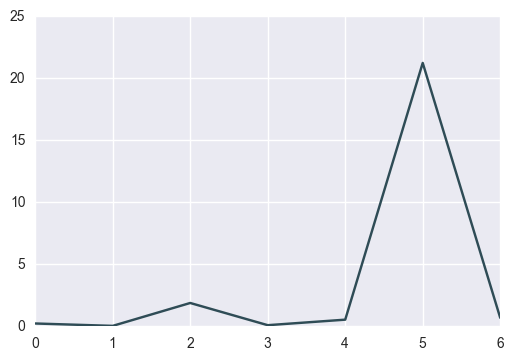

In [93]:
results_df.time.plot()

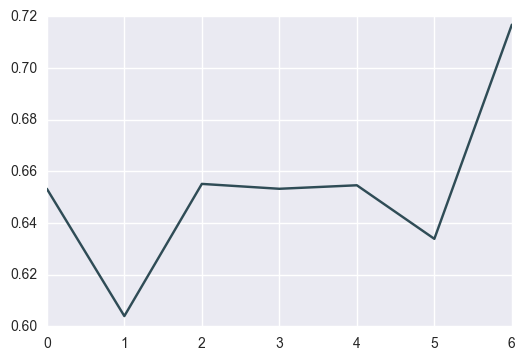

In [97]:
results_df['auc-roc'].plot()

In [105]:
results_df = read_data('results.csv')